In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

In [2]:
## ignore the future decpreciation warnings in CatBoost and RandomForest
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
df = pd.read_csv('data_modified.csv', low_memory=False)
df = df.drop(columns=['Unnamed: 0', 'Description', 'Reference number', 'Location', 'Functions'])
df = df.dropna()
print(df.shape)
df.head()

(46090, 29)


,Bracelet material,Brand,Case diameter,Case material,Condition,Dial,Gender,Model,Movement,Scope of delivery,...,Chronograph,GMT,Tachymeter,Moon phase,Annual calendar,Perpetual calendar,Tourbillon,Flyback,Alarm,Country
0,Steel,Bulgari,41.0,Steel,New,Black,Men's watch/Unisex,Octo,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,United States of America
1,Steel,Tissot,39.0,Steel,New,Mother of pearl,Men's watch/Unisex,PR 100,Quartz,"Original box, no original papers",...,0,0,0,0,0,0,0,0,0,Japan
2,Leather,Mido,41.0,Steel,New,Silver,Men's watch/Unisex,Belluna,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan
3,Steel,Mido,42.0,Steel,New,Black,Men's watch/Unisex,Multifort GMT,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan
4,Leather,Seiko,42.0,Steel,Unworn,Black,Men's watch/Unisex,Kinetic,Quartz,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan


# 1. Exploratory analysis

To see how suitable some of the features are to differentiate between different watch brands, I examine their distribution between the top 10 brands by number of offerings. <br>
I use the odds-ratio (OR) to determine how the values of a features impact the likelihood that a watch belongs to a certain brand. <br> 
The odds ratio is defined as the odds that a watch is of a given brand divided by the odds that a watch is of a given brand when the feature has a certain value. For example, if the brand is 'Omega' and the value of the feature 'Movement' is 'Manual winding', an Odds-ratio of 5 implies that a watch with a hand-wound movement is 5 times more likely to be an Omega compared to the base probability.

\begin{equation*}
OR^{>1} = \frac{R(Brand)}{R(Brand^{feat})}
\end{equation*}

A given feature-value can also decrease the odds of a certain brand to be present. The odds-ratio would then be between 0 and 1. <br>
To make this case more comparable, I modify Odds-ratios below 1 by taking the negative reciprocal. <br>
To follow the example above, if the brand is 'Rolex' and the value of the feature 'Movement' is 'Manual winding', an Odds-ratio of -4 implies that a watch with a hand-wound movement is 4 times less likely to be a Rolex compared to the base probability.

\begin{equation*}
OR^{<1} = -\frac{1}{OR^{>1}}
\end{equation*}

Lastly, there are also cases where a given brand never has a certain feature-value. Or alternatively, a given feature-value is only ever displayed by one specific brand. <br>
The odds-ratio would be zero in this case. I replace the odds-ratio with -999 or 999 respectively, to make this information more visible.

The individual features will probably increase their information value significantly when combined with other features. <br>

In [22]:
## get the ten most frequent brands
print(df['Brand'].value_counts()[0:10])
top_brands = df['Brand'].value_counts()[0:10]

Rolex             13050
Omega              4438
Cartier            2107
Breitling          1943
Seiko              1917
TAG Heuer          1715
Longines           1484
Hublot             1227
Patek Philippe     1167
Tudor              1138
Name: Brand, dtype: int64


In [23]:
## calculate odds-ratio based on the formula above
def get_brand_dist(feature):
    t = pd.DataFrame(columns=df[feature].unique(), index=top_brands.index.values)
    
    for brand in top_brands.index.values:
        odd1 = len(df[df['Brand'] == brand]) / len(df[(df['Brand'].isin(top_brands.index.values)) & (df['Brand'] != brand)])
        r = []
        for value in df[feature].unique():
            ## exception if none of the top-10 brands have a certain feature value
            try:
                target = len(df[(df['Brand'] == brand) & (df[feature] == value)])
                rest = len(df[(df['Brand'].isin(top_brands.index.values)) & (df['Brand'] != brand) & (df[feature] == value)])
                
                if target == 0:
                    x = -999
                elif rest == 0:
                    x = 999
                else:
                    x = (target/rest)/odd1
                    if x < 1:
                        x = -1/x
            except:
                x = 0
            r.append(x)
        t.loc[brand] = r
    
    t = t.apply(pd.to_numeric)
    return(t)

In [24]:
## apply styling to the dataframe, red hues for reduced odds, green hues for increased odds
def centered_background_gradient(s):
    cmap = plt.cm.get_cmap('RdYlGn')
    norm = plt.colors.TwoSlopeNorm(vmin=-30, vcenter=0, vmax=30)
    return ['background-color: {:s}'.format(plt.colors.to_hex(c.flatten())) for c in cmap(norm(s.values))]

## 1.1 Movement
The type of movement offers some differentiation between brands. <br>
Automatic movements are the default, so the odds ratios are close to 1 in most cases. <br>
A quartz movement significantly increases the odds that a watch is made by Cartier. In contrast to this, Rolex and its daughter company Tudor have almost no quartz watches in their portfolio (Rolex has only produced a single quartz model in their history). <br>
A manually-wound watch is more likely to be an Omega, famous for their hand-wound Speedmaster, or one of the many hand-wound dress watches by Patek Phillipe.

In [25]:
get_brand_dist('Movement').style.apply(centered_background_gradient)

,Automatic,Quartz,Manual winding
Rolex,1.382586,-33.796308,-4.582402
Omega,-1.217173,-1.026445,5.880307
Cartier,-2.020800,5.357727,1.356001
Breitling,1.015900,1.110050,-1.904558
Seiko,-1.091823,1.911581,-2.849922
TAG Heuer,-1.327220,3.351334,-8.147018
Longines,-1.262322,3.002324,-12.024807
Hublot,1.099246,-1.617205,-2.523384
Patek Philippe,-1.259966,-1.249786,5.205007
Tudor,1.210269,-14.538412,-15.974232


## 1.2 Crystal
As with the movement, the default value, a sapphire crystal, offers little information for separating brands. <br>
Mineral glass is rarely found in the second most expensive brand on this list, Rolex. The use of mineral glass increases the odds that a watch is made by Seiko, the most affordable brand on this list fourty-fold. <br>
Plexiglass is used by most manufacturers, mostly in vintage models. Hublot, the youngest brand on the list does not have a single watch with a plexiglass crystal, signified by the OR of -999.

In [26]:
get_brand_dist('Crystal').style.apply(centered_background_gradient)

,Sapphire crystal,Mineral Glass,Plexiglass
Rolex,1.042205,-53.133080,1.190534
Omega,-1.237836,-1.429393,4.054840
Cartier,1.088532,1.321508,-15.134645
Breitling,1.106615,-2.568377,-5.110546
Seiko,-1.465228,39.089873,-2.448902
TAG Heuer,1.118499,-9.176062,-5.608470
Longines,1.108028,-11.840151,-3.630439
Hublot,1.137017,-12.951172,-999.000000
Patek Philippe,1.101876,-2.272149,-5.005814
Tudor,1.038375,-8.971427,-1.070825


## 1.3 Materials
Case and bracelet materials are very useful for separating brands. <br>
While common materials like steel and yellow gold are used by all brands to some extent, there are a lot of materials that are used by only a few manufacturers. For most materials you have at least one brand with a very high odds-ratio and multiple ones with the minimum value of -999. <br>
For example only five brands use platinum cases and only two platinum bracelets. <br>
Aluminium cases are used exclusively by Seiko which makes classification easy in this case.

In [27]:
get_brand_dist('Case material').style.apply(centered_background_gradient)

,Steel,Gold/Steel,Yellow gold,Titanium,Platinum,Rose gold,White gold,Ceramic,Bronze,Carbon,Plastic,Silver,Aluminum,Other
Rolex,-1.088768,2.996996,1.688069,-999.000000,1.545805,-1.561101,1.445276,-176.680672,-999.000000,-999.000000,-999.000000,-11.677171,-999,-999
Omega,1.221180,-1.620956,-2.103486,-1.090666,-9.709777,-1.743572,-5.956096,1.275769,-1.964937,-2.843988,-9.479960,-4.050528,-999,-999
Cartier,-1.351104,1.278065,2.895371,-999.000000,-3.151608,1.499097,2.487399,-999.000000,-999.000000,-5.177642,-999.000000,25.085234,-999,-999
Breitling,1.135892,-1.212479,-4.125725,1.989903,-999.000000,-1.499515,-999.000000,-31.990051,-999.000000,3.007401,392.465775,-6.673193,-999,-999
Seiko,1.372111,-16.260540,-13.989780,2.444603,-999.000000,-30.334925,-65.032474,-4.446582,-999.000000,-999.000000,-999.000000,-999.000000,999,-999
TAG Heuer,1.359211,-6.708364,-31.157450,1.562218,-999.000000,-11.513821,-999.000000,1.101679,-1.807102,1.277013,-3.313020,-999.000000,-999,-999
Longines,1.265969,-1.657053,-3.010633,-3.705433,-999.000000,-1.107321,-999.000000,-24.042227,2.072247,-999.000000,-999.000000,-999.000000,-999,-999
Hublot,-4.789243,-6.759063,-6.231453,18.228775,-7.245312,6.317452,-20.295349,40.715981,-2.584585,51.494110,-999.000000,-999.000000,-999,-999
Patek Philippe,-2.699185,-15.022548,3.787311,-999.000000,17.480287,5.237372,10.033780,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999,-999
Tudor,1.167833,-2.550316,-8.984485,1.785218,-999.000000,-999.000000,-999.000000,2.863240,87.515943,-999.000000,-999.000000,7.827815,-999,-999


In [28]:
get_brand_dist('Bracelet material').style.apply(centered_background_gradient)

,Steel,Leather,Gold/Steel,Rubber,Titanium,Yellow gold,Platinum,Textile,Rose gold,White gold,Ceramic,Aluminium,Silver
Rolex,1.315856,-7.520352,4.640224,-6.424810,-999.000000,3.874265,36.329195,-98.240546,1.628248,3.885162,-999.000000,-999,-1.903887
Omega,1.143319,1.481145,-3.487622,-1.369212,1.489328,-3.493221,-999.000000,1.497216,-2.490347,-2.979416,-4.481435,-999,2.320685
Cartier,-1.698465,2.296879,1.332653,-2.183208,-999.000000,1.924279,-999.000000,-4.105666,1.025118,1.903790,-999.000000,-999,-999.000000
Breitling,-1.311968,1.720905,-4.456889,3.143727,2.076538,-12.471697,-999.000000,2.386470,-3.013256,-999.000000,-1.788691,-999,2.422628
Seiko,1.172581,-1.061145,-37.850844,1.187732,7.440884,-999.000000,-999.000000,6.015712,-999.000000,-999.000000,-999.000000,-999,5.898592
TAG Heuer,1.155957,1.286706,-7.157415,1.442171,1.020784,-12.750108,-999.000000,1.185798,-999.000000,-999.000000,5.263784,-999,-999.000000
Longines,-1.066157,1.993425,-1.325010,-1.968369,-5.601236,-5.945927,-999.000000,-3.309038,1.094772,-999.000000,-1.344297,-999,-999.000000
Hublot,-98.238445,1.602713,-47.341690,11.023347,2.375987,-999.000000,-999.000000,3.550663,2.898426,-999.000000,43.476387,-999,-999.000000
Patek Philippe,-3.257621,3.448844,-11.203238,1.566756,-999.000000,1.619009,-1.112616,-5.187739,3.552332,1.955778,-999.000000,-999,-999.000000
Tudor,1.205073,1.090495,-2.538025,-2.869028,5.483252,-999.000000,-999.000000,3.413291,-999.000000,-999.000000,-999.000000,-999,-999.000000


## 1.4 Functions

In [29]:
get_brand_dist('Perpetual calendar').style.apply(centered_background_gradient)

,0,1
Rolex,-1.008350,2.074904
Omega,1.010889,-6.300822
Cartier,1.011667,-25.287902
Breitling,1.005986,-2.045112
Seiko,1.007589,-2.797278
TAG Heuer,1.012014,-999.000000
Longines,-1.011875,2.092630
Hublot,1.009230,-4.731344
Patek Philippe,-1.050010,6.033740
Tudor,1.011773,-999.000000


In [30]:
get_brand_dist('Tourbillon').style.apply(centered_background_gradient)

,0,1
Rolex,1.002340,-999.000000
Omega,1.001556,-999.000000
Cartier,1.001427,-999.000000
Breitling,1.001418,-999.000000
Seiko,1.001417,-999.000000
TAG Heuer,-1.014258,27.668610
Longines,1.001396,-999.000000
Hublot,-1.008036,8.952281
Patek Philippe,-1.000405,1.308754
Tudor,-1.000450,1.343446


# 2. Feature Engineering

In [4]:
df = df[df["Year of production"] > 1900]
df['Decade'] = 0
for i in range(190, 220):
    start = i * 10
    end = start + 10
    df.loc[(df['Year of production'] >= start) & (df['Year of production'] < end), 'Decade'] = '{}s'.format(start)

In [5]:
df = df.loc[df['Case diameter'] > 14]
df['Diameter_group'] = 0
for i in range(0, 24):
    start = 14 + i*2
    end = start + 1
    df.loc[(df['Case diameter'] >= start) & (df['Case diameter'] <= end), 'Diameter_group'] = '{}-{}'.format(start, end)

In [6]:
keep = df['Brand'].value_counts()
keep = keep[keep>4]
keep = keep.index.get_level_values(0).astype(str).values
df = df[df['Brand'].isin(keep)]

In [7]:
df = df.dropna()

# 3. Feature Based Classification

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, ParameterGrid
from category_encoders.binary import BinaryEncoder
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier, Pool
import time

In [9]:
categorical_var = ['Bracelet material', 'Case material',
       'Condition', 'Dial', 'Gender', 'Movement', 'Scope of delivery',
       'private_seller', 'Crystal', 'Decade', 'Diameter_group', 'Country']

In [10]:
functions = ['Date', 'Weekday', 'Month', 'Year', 'Chronograph', 'GMT', 
             'Tachymeter', 'Moon phase', 'Annual calendar', 'Perpetual calendar',
             'Tourbillon', 'Flyback', 'Alarm']

In [11]:
X = df[categorical_var + functions]
y = df['Brand']

## 3.1 First test of different classifiers
In the first step, the categorical data has to be numerically encoded. <br>
The default solution is a onehot dummy encoding. As a downside, this will result in a very large number of variables, making the regression much slower. <br>
Binary encoding is a viable alternative resulting in significantly less variables. On the flipside, this method will have some information loss compared to dummy encoding. In addition, the logistic regression model will have some problems with binary encoding, as it does not natively take variable interactions into account. With tree based models this problem is alleviated. <br>
I test out three classification models:
1. A simple logistic regression model
2. A K-nearest Neighbours model
3. A decision-tree ensemble model (Random Forest)
<br>
<br>
The baseline results are quite promising, the three classification models have accuracies of 53%, 56% and 61% respectively. <br>
As in the regression problem, the Random Forest model delivers the best results, but it is quite slow with onehot encoding. <br>
Using binary encoding we can observe a trade-off of 1% drop in accuracy for a 4 time speed-up of the calculation.

In [39]:
%%time

transformers = [
    ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_var)], remainder='passthrough'),
    ColumnTransformer([('binary', BinaryEncoder(), categorical_var)], remainder='passthrough'),
]

models = [
    LogisticRegression(random_state=13, max_iter=1000),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=13),
]


for transformer in transformers:
    print(transformer.transformers[0][0])
    for model in models:
        start_time = time.time()
        pipe = Pipeline([('tf', transformer), ('model', model)])
        scores = cross_val_score(pipe, X, y, cv=5, n_jobs=5)
        print('{}. Score: {}. Time: {}s'.format(model, np.mean(scores), time.time() - start_time))

onehot
LogisticRegression(max_iter=1000, random_state=13). Score: 0.5301291562105177. Time: 249.27463603019714s
KNeighborsClassifier(). Score: 0.5568217284050645. Time: 16.25243067741394s
RandomForestClassifier(random_state=13). Score: 0.6137308273896627. Time: 45.370914697647095s
binary
LogisticRegression(max_iter=1000, random_state=13). Score: 0.4787891478371587. Time: 330.26024317741394s
KNeighborsClassifier(). Score: 0.5367643250138233. Time: 10.605016708374023s
RandomForestClassifier(random_state=13). Score: 0.6021794064919821. Time: 10.228172302246094s
Wall time: 11min 1s


## 3.3 Gradient boosting
It might be possible to increase accuracy even more with gradient boosting. <br>
I use the CatBoost algorithm as an implementation of gradient boosting. The catboost package comes with two very useful features. First of all it supports calculation on GPU natively, which significantly speeds of calculation. Secondly, encoding is handled internally and allows for easy output of feature importance. <br>
<br>
After 1000 iterations, CatBoost achieves an accuracy of 61%. The results are comparable to the Random Forest classifier, but the calculation is significantly slower. <br>
Case diameter is by far the most important feature. <br>
It is surprising to see the selling country to have such a high importance. 

In [12]:
df['private_seller'] = df['private_seller'].astype(int)
X = df[categorical_var + functions]

In [13]:
%%time

model = CatBoostClassifier(cat_features=categorical_var, iterations=1000, random_state=13, task_type='GPU', devices='0:1', early_stopping_rounds=10, verbose=False)
np.mean(cross_val_score(model, X, y, cv=5, n_jobs=1))

Wall time: 13min 43s


0.6170157557860382

In [14]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model.fit(X_train, y_train)

Wall time: 2min 47s


Wall time: 401 ms


<AxesSubplot:xlabel='feature', ylabel='importance'>

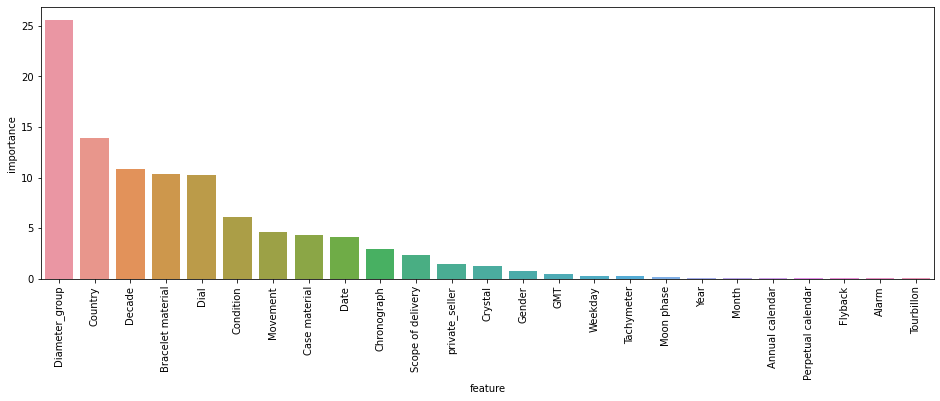

In [19]:
%%time

pool = Pool(X_train, label=y_train, cat_features=categorical_var)
fi = model.get_feature_importance(pool)

df_fi = pd.DataFrame({
    'feature': X.columns,
    'importance': fi
})

plt.pyplot.figure(figsize=(16,5))
plt.pyplot.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=df_fi.sort_values('importance', ascending=False))

## 3.2 Hyperparameter tuning for Random Forest
The random forest regression has delivered the best results so far. <br>
I try to optimize the model by tuning the hyperparameters. Since the model takes a fairly long time to run, I use a randomized search grid. <br>
With the optimized parameters, the model improves only slightly by 0.03%. The base parameters seem to be very close to ideal already.

In [17]:
%%time

params = [
    {'model__max_depth': [50, 100, 200, None],
     'model__max_features': ['log2', 'auto'],
     'model__min_samples_leaf': [1, 2],
     'model__min_samples_split': [2, 5, 10],
     'model__n_estimators': [100, 200, 500]}]


transformer = ColumnTransformer([
        ('cat', BinaryEncoder(), categorical_var),
    ], remainder='passthrough')


pipe = Pipeline([('tf', transformer), ('model',RandomForestClassifier(random_state=13, n_jobs=5))])

grid = RandomizedSearchCV(estimator=pipe,
             param_distributions=params, n_jobs=1, n_iter=100, cv=3, verbose=1, random_state=13)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

{'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': None}
0.5914113107143263
Wall time: 32min 17s


In [18]:
transformer = ColumnTransformer([('binary', BinaryEncoder(), categorical_var)], remainder='passthrough')

pipe = Pipeline([('tf', transformer), ('model',RandomForestClassifier(random_state=13, n_jobs=5, 
                                       n_estimators= 200, 
                                       min_samples_split=5,
                                       min_samples_leaf=1,
                                       max_features='auto',
                                       max_depth = None))])


np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=5))

0.6024405788128746

# 4. Image based classification
The offerings on Chrono24 usually contain a picture of the watch. <br>
In an earlier step I have used text recongnition to extract words that are present on the watch dial. Since recognition is often times imperfect, the resulting words have been clustered by similarity. For example, Rolex, olex, Role or Boiex would all be in the same cluster. <br>
I use the occurence of clusters in each watch as the features for a second classification.

In [34]:
df_words = pd.read_csv('word_clusters.csv', low_memory=False)
df = df.merge(df_words, on='id')

X = df[map(str, range(0, 389))]
y = df['Brand']

## 4.1 First test of different classifiers
The K-nearest neighbors classifier seems to have problems with the sparse binary dataset and results in an accuracy of just 41%. <br>
A logistic regression and a random forest model have significantly better results of 57% and 55% respectively. <br>

In [24]:
%%time

models = [
    LogisticRegression(random_state=13, max_iter=1000),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=13),
]


for model in models:
    start_time = time.time()
    scores = cross_val_score(model, X, y, cv=5, n_jobs=5)
    print('{}. Score: {}. Time: {}s'.format(model, np.mean(scores), time.time() - start_time))

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


LogisticRegression(max_iter=1000, random_state=13). Score: 0.5656471125313856. Time: 92.00567746162415s


C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


KNeighborsClassifier(). Score: 0.4074640493038119. Time: 12.727590084075928s


C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


RandomForestClassifier(random_state=13). Score: 0.55243095183748. Time: 35.154783487319946s
Wall time: 2min 19s


## 4.2 Hyperparameter tuning for random forest
The logistic regression performed slightly better than the random forest classifier, but its runtime is also almost three times as long. <br>
I try tuning the hyperparameters of the random forest model to improve performance. <br>
Using a randomized search grid, I was able to find hyper parameters that increase performance to 57%, marginally overtaking the logistic regression.

In [16]:
%%time

params = [
    {'max_depth': [200, 500, None],
     'max_features': ['auto', 'log2'],
     'min_samples_leaf': [1, 2],
     'min_samples_split': [2, 20, 50],
     'n_estimators': [100, 200, 500]}]



grid = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=13, n_jobs=5),
             param_distributions=params, n_jobs=1, n_iter=100, cv=3, verbose=1, random_state=13)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 200}
0.5628397402161429
Wall time: 52min 6s


In [19]:
%%time

model = RandomForestClassifier(random_state=13, n_jobs=5, 
                                       n_estimators= 500, 
                                       min_samples_split=20,
                                       min_samples_leaf=1,
                                       max_features='log2',
                                       max_depth = 200)


np.mean(cross_val_score(model, X, y, cv=5, n_jobs=5))

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 1min 1s


0.5657384158867839

## 4.3 Gradient boosting
CatBoost has an accuracy of 56%. But it is again very time intensive.

In [16]:
%%time


params = [
    {'depth': [4, 6, 8]}]


model = CatBoostClassifier(random_state=13, task_type='GPU',loss_function='MultiClass', eval_metric = 'Accuracy', devices='0:1', early_stopping_rounds=10)

grid = GridSearchCV(estimator=model,
             param_grid=params, n_jobs=1, cv=3, verbose=1)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Learning rate set to 0.129193
0:	learn: 0.3337670	total: 34.9ms	remaining: 34.9s
1:	learn: 0.3733137	total: 67.8ms	remaining: 33.8s
2:	learn: 0.3974526	total: 101ms	remaining: 33.6s
3:	learn: 0.4142984	total: 135ms	remaining: 33.7s
4:	learn: 0.4181333	total: 170ms	remaining: 33.9s
5:	learn: 0.4309388	total: 203ms	remaining: 33.7s
6:	learn: 0.4309388	total: 236ms	remaining: 33.5s
7:	learn: 0.4309388	total: 272ms	remaining: 33.7s
8:	learn: 0.4326508	total: 304ms	remaining: 33.4s
9:	learn: 0.4332329	total: 337ms	remaining: 33.4s
10:	learn: 0.4366911	total: 369ms	remaining: 33.2s
11:	learn: 0.4393960	total: 404ms	remaining: 33.2s
12:	learn: 0.4434705	total: 439ms	remaining: 33.3s
13:	learn: 0.4486407	total: 474ms	remaining: 33.4s
14:	learn: 0.4486407	total: 509ms	remaining: 33.4s
15:	learn: 0.4491885	total: 541ms	remaining: 33.3s
16:	learn: 0.4528179	total: 574ms	remaining: 33.2s
17:	learn: 0.4565158	total: 607ms	remaining: 33.1s
1

161:	learn: 0.5304047	total: 5.42s	remaining: 28s
162:	learn: 0.5304047	total: 5.46s	remaining: 28s
163:	learn: 0.5305074	total: 5.49s	remaining: 28s
164:	learn: 0.5306101	total: 5.53s	remaining: 28s
165:	learn: 0.5306786	total: 5.56s	remaining: 27.9s
166:	learn: 0.5308841	total: 5.59s	remaining: 27.9s
167:	learn: 0.5312265	total: 5.62s	remaining: 27.9s
168:	learn: 0.5314661	total: 5.66s	remaining: 27.8s
169:	learn: 0.5316716	total: 5.69s	remaining: 27.8s
170:	learn: 0.5319455	total: 5.72s	remaining: 27.7s
171:	learn: 0.5319113	total: 5.76s	remaining: 27.7s
172:	learn: 0.5322879	total: 5.8s	remaining: 27.7s
173:	learn: 0.5326988	total: 5.84s	remaining: 27.7s
174:	learn: 0.5328015	total: 5.88s	remaining: 27.7s
175:	learn: 0.5329042	total: 5.92s	remaining: 27.7s
176:	learn: 0.5329384	total: 5.95s	remaining: 27.7s
177:	learn: 0.5329384	total: 5.99s	remaining: 27.7s
178:	learn: 0.5331781	total: 6.03s	remaining: 27.7s
179:	learn: 0.5332466	total: 6.07s	remaining: 27.6s
180:	learn: 0.5333151

321:	learn: 0.5458467	total: 11.1s	remaining: 23.3s
322:	learn: 0.5459495	total: 11.1s	remaining: 23.3s
323:	learn: 0.5459495	total: 11.1s	remaining: 23.2s
324:	learn: 0.5461207	total: 11.2s	remaining: 23.2s
325:	learn: 0.5461891	total: 11.2s	remaining: 23.2s
326:	learn: 0.5462576	total: 11.2s	remaining: 23.1s
327:	learn: 0.5463946	total: 11.3s	remaining: 23.1s
328:	learn: 0.5463946	total: 11.3s	remaining: 23.1s
329:	learn: 0.5465658	total: 11.4s	remaining: 23.1s
330:	learn: 0.5466000	total: 11.4s	remaining: 23s
331:	learn: 0.5467712	total: 11.4s	remaining: 23s
332:	learn: 0.5469766	total: 11.5s	remaining: 22.9s
333:	learn: 0.5470451	total: 11.5s	remaining: 22.9s
334:	learn: 0.5471821	total: 11.5s	remaining: 22.9s
335:	learn: 0.5471478	total: 11.6s	remaining: 22.9s
336:	learn: 0.5471478	total: 11.6s	remaining: 22.8s
337:	learn: 0.5471821	total: 11.6s	remaining: 22.8s
338:	learn: 0.5472163	total: 11.7s	remaining: 22.8s
339:	learn: 0.5472848	total: 11.7s	remaining: 22.7s
340:	learn: 0.54

480:	learn: 0.5553653	total: 16.8s	remaining: 18.1s
481:	learn: 0.5553653	total: 16.8s	remaining: 18.1s
482:	learn: 0.5554681	total: 16.9s	remaining: 18.1s
483:	learn: 0.5556050	total: 16.9s	remaining: 18s
484:	learn: 0.5557420	total: 16.9s	remaining: 18s
485:	learn: 0.5559132	total: 17s	remaining: 18s
486:	learn: 0.5564268	total: 17s	remaining: 17.9s
487:	learn: 0.5564268	total: 17.1s	remaining: 17.9s
488:	learn: 0.5563925	total: 17.1s	remaining: 17.9s
489:	learn: 0.5563925	total: 17.1s	remaining: 17.8s
490:	learn: 0.5564268	total: 17.2s	remaining: 17.8s
491:	learn: 0.5564952	total: 17.2s	remaining: 17.8s
492:	learn: 0.5565637	total: 17.3s	remaining: 17.7s
493:	learn: 0.5566322	total: 17.3s	remaining: 17.7s
494:	learn: 0.5566322	total: 17.3s	remaining: 17.7s
495:	learn: 0.5570088	total: 17.4s	remaining: 17.6s
496:	learn: 0.5570088	total: 17.4s	remaining: 17.6s
497:	learn: 0.5570088	total: 17.4s	remaining: 17.6s
498:	learn: 0.5570088	total: 17.5s	remaining: 17.6s
499:	learn: 0.5571116	

643:	learn: 0.5653633	total: 22.6s	remaining: 12.5s
644:	learn: 0.5654318	total: 22.6s	remaining: 12.4s
645:	learn: 0.5653975	total: 22.7s	remaining: 12.4s
646:	learn: 0.5655002	total: 22.7s	remaining: 12.4s
647:	learn: 0.5656714	total: 22.7s	remaining: 12.4s
648:	learn: 0.5658084	total: 22.8s	remaining: 12.3s
649:	learn: 0.5658084	total: 22.8s	remaining: 12.3s
650:	learn: 0.5660138	total: 22.9s	remaining: 12.3s
651:	learn: 0.5660138	total: 22.9s	remaining: 12.2s
652:	learn: 0.5659111	total: 23s	remaining: 12.2s
653:	learn: 0.5659111	total: 23s	remaining: 12.2s
654:	learn: 0.5659111	total: 23.1s	remaining: 12.2s
655:	learn: 0.5659111	total: 23.1s	remaining: 12.1s
656:	learn: 0.5659454	total: 23.2s	remaining: 12.1s
657:	learn: 0.5659454	total: 23.2s	remaining: 12.1s
658:	learn: 0.5661508	total: 23.3s	remaining: 12s
659:	learn: 0.5661850	total: 23.3s	remaining: 12s
660:	learn: 0.5662877	total: 23.4s	remaining: 12s
661:	learn: 0.5662535	total: 23.4s	remaining: 12s
662:	learn: 0.5663562	to

806:	learn: 0.5727933	total: 29.2s	remaining: 6.99s
807:	learn: 0.5727590	total: 29.3s	remaining: 6.96s
808:	learn: 0.5727590	total: 29.3s	remaining: 6.92s
809:	learn: 0.5727590	total: 29.4s	remaining: 6.88s
810:	learn: 0.5727590	total: 29.4s	remaining: 6.85s
811:	learn: 0.5727933	total: 29.4s	remaining: 6.81s
812:	learn: 0.5731014	total: 29.5s	remaining: 6.78s
813:	learn: 0.5731699	total: 29.5s	remaining: 6.74s
814:	learn: 0.5730672	total: 29.6s	remaining: 6.71s
815:	learn: 0.5730672	total: 29.6s	remaining: 6.67s
816:	learn: 0.5731014	total: 29.6s	remaining: 6.64s
817:	learn: 0.5731014	total: 29.7s	remaining: 6.6s
818:	learn: 0.5731014	total: 29.7s	remaining: 6.57s
819:	learn: 0.5730672	total: 29.8s	remaining: 6.53s
820:	learn: 0.5732384	total: 29.8s	remaining: 6.5s
821:	learn: 0.5734438	total: 29.9s	remaining: 6.46s
822:	learn: 0.5734438	total: 29.9s	remaining: 6.43s
823:	learn: 0.5734438	total: 29.9s	remaining: 6.39s
824:	learn: 0.5734438	total: 30s	remaining: 6.36s
825:	learn: 0.57

969:	learn: 0.5775868	total: 35.4s	remaining: 1.09s
970:	learn: 0.5775526	total: 35.4s	remaining: 1.06s
971:	learn: 0.5774498	total: 35.5s	remaining: 1.02s
972:	learn: 0.5774841	total: 35.5s	remaining: 985ms
973:	learn: 0.5775868	total: 35.5s	remaining: 948ms
974:	learn: 0.5775868	total: 35.6s	remaining: 912ms
975:	learn: 0.5775868	total: 35.6s	remaining: 875ms
976:	learn: 0.5776210	total: 35.6s	remaining: 839ms
977:	learn: 0.5776210	total: 35.7s	remaining: 802ms
978:	learn: 0.5776895	total: 35.7s	remaining: 766ms
979:	learn: 0.5776895	total: 35.7s	remaining: 729ms
980:	learn: 0.5777238	total: 35.8s	remaining: 693ms
981:	learn: 0.5777238	total: 35.8s	remaining: 656ms
982:	learn: 0.5777580	total: 35.8s	remaining: 620ms
983:	learn: 0.5777922	total: 35.9s	remaining: 583ms
984:	learn: 0.5777922	total: 35.9s	remaining: 547ms
985:	learn: 0.5777922	total: 35.9s	remaining: 510ms
986:	learn: 0.5778950	total: 36s	remaining: 474ms
987:	learn: 0.5779634	total: 36s	remaining: 437ms
988:	learn: 0.57

130:	learn: 0.5140548	total: 4.5s	remaining: 29.8s
131:	learn: 0.5140891	total: 4.53s	remaining: 29.8s
132:	learn: 0.5140891	total: 4.56s	remaining: 29.7s
133:	learn: 0.5145684	total: 4.59s	remaining: 29.7s
134:	learn: 0.5146711	total: 4.63s	remaining: 29.7s
135:	learn: 0.5147396	total: 4.66s	remaining: 29.6s
136:	learn: 0.5147396	total: 4.7s	remaining: 29.6s
137:	learn: 0.5148766	total: 4.73s	remaining: 29.5s
138:	learn: 0.5184716	total: 4.76s	remaining: 29.5s
139:	learn: 0.5149108	total: 4.79s	remaining: 29.5s
140:	learn: 0.5150820	total: 4.83s	remaining: 29.4s
141:	learn: 0.5151505	total: 4.87s	remaining: 29.4s
142:	learn: 0.5154244	total: 4.9s	remaining: 29.4s
143:	learn: 0.5154929	total: 4.94s	remaining: 29.4s
144:	learn: 0.5157668	total: 4.97s	remaining: 29.3s
145:	learn: 0.5197042	total: 5.01s	remaining: 29.3s
146:	learn: 0.5197042	total: 5.04s	remaining: 29.2s
147:	learn: 0.5197384	total: 5.07s	remaining: 29.2s
148:	learn: 0.5198069	total: 5.11s	remaining: 29.2s
149:	learn: 0.5

290:	learn: 0.5400075	total: 9.93s	remaining: 24.2s
291:	learn: 0.5399733	total: 9.96s	remaining: 24.2s
292:	learn: 0.5400418	total: 10s	remaining: 24.1s
293:	learn: 0.5401787	total: 10s	remaining: 24.1s
294:	learn: 0.5402130	total: 10.1s	remaining: 24.1s
295:	learn: 0.5403157	total: 10.1s	remaining: 24s
296:	learn: 0.5403842	total: 10.1s	remaining: 24s
297:	learn: 0.5404184	total: 10.2s	remaining: 23.9s
298:	learn: 0.5404526	total: 10.2s	remaining: 23.9s
299:	learn: 0.5406581	total: 10.2s	remaining: 23.9s
300:	learn: 0.5406923	total: 10.3s	remaining: 23.9s
301:	learn: 0.5406923	total: 10.3s	remaining: 23.8s
302:	learn: 0.5406238	total: 10.3s	remaining: 23.8s
303:	learn: 0.5406923	total: 10.4s	remaining: 23.7s
304:	learn: 0.5407265	total: 10.4s	remaining: 23.7s
305:	learn: 0.5407950	total: 10.4s	remaining: 23.7s
306:	learn: 0.5409320	total: 10.5s	remaining: 23.6s
307:	learn: 0.5410004	total: 10.5s	remaining: 23.6s
308:	learn: 0.5412059	total: 10.5s	remaining: 23.6s
309:	learn: 0.541787

453:	learn: 0.5526757	total: 15.9s	remaining: 19.1s
454:	learn: 0.5526757	total: 15.9s	remaining: 19.1s
455:	learn: 0.5526757	total: 16s	remaining: 19s
456:	learn: 0.5527784	total: 16s	remaining: 19s
457:	learn: 0.5528127	total: 16s	remaining: 19s
458:	learn: 0.5528127	total: 16.1s	remaining: 19s
459:	learn: 0.5529154	total: 16.1s	remaining: 18.9s
460:	learn: 0.5529154	total: 16.2s	remaining: 18.9s
461:	learn: 0.5528812	total: 16.2s	remaining: 18.9s
462:	learn: 0.5528812	total: 16.2s	remaining: 18.8s
463:	learn: 0.5530524	total: 16.3s	remaining: 18.8s
464:	learn: 0.5530866	total: 16.3s	remaining: 18.8s
465:	learn: 0.5532235	total: 16.4s	remaining: 18.8s
466:	learn: 0.5533947	total: 16.4s	remaining: 18.7s
467:	learn: 0.5536002	total: 16.5s	remaining: 18.7s
468:	learn: 0.5537371	total: 16.5s	remaining: 18.7s
469:	learn: 0.5537029	total: 16.5s	remaining: 18.6s
470:	learn: 0.5536686	total: 16.6s	remaining: 18.6s
471:	learn: 0.5537029	total: 16.6s	remaining: 18.6s
472:	learn: 0.5535659	tota

616:	learn: 0.5617489	total: 21.6s	remaining: 13.4s
617:	learn: 0.5617489	total: 21.6s	remaining: 13.4s
618:	learn: 0.5617489	total: 21.7s	remaining: 13.3s
619:	learn: 0.5617489	total: 21.7s	remaining: 13.3s
620:	learn: 0.5617831	total: 21.7s	remaining: 13.3s
621:	learn: 0.5618174	total: 21.8s	remaining: 13.2s
622:	learn: 0.5618174	total: 21.8s	remaining: 13.2s
623:	learn: 0.5618516	total: 21.8s	remaining: 13.2s
624:	learn: 0.5618516	total: 21.9s	remaining: 13.1s
625:	learn: 0.5618516	total: 21.9s	remaining: 13.1s
626:	learn: 0.5618516	total: 21.9s	remaining: 13.1s
627:	learn: 0.5618516	total: 22s	remaining: 13s
628:	learn: 0.5619543	total: 22s	remaining: 13s
629:	learn: 0.5619543	total: 22s	remaining: 12.9s
630:	learn: 0.5619543	total: 22.1s	remaining: 12.9s
631:	learn: 0.5620228	total: 22.1s	remaining: 12.9s
632:	learn: 0.5620228	total: 22.1s	remaining: 12.8s
633:	learn: 0.5621940	total: 22.2s	remaining: 12.8s
634:	learn: 0.5622625	total: 22.2s	remaining: 12.8s
635:	learn: 0.5621940	

777:	learn: 0.5683227	total: 27.2s	remaining: 7.75s
778:	learn: 0.5684254	total: 27.2s	remaining: 7.72s
779:	learn: 0.5684254	total: 27.2s	remaining: 7.68s
780:	learn: 0.5684596	total: 27.3s	remaining: 7.65s
781:	learn: 0.5684254	total: 27.3s	remaining: 7.61s
782:	learn: 0.5683569	total: 27.3s	remaining: 7.58s
783:	learn: 0.5684596	total: 27.4s	remaining: 7.54s
784:	learn: 0.5684939	total: 27.4s	remaining: 7.51s
785:	learn: 0.5683911	total: 27.4s	remaining: 7.47s
786:	learn: 0.5683569	total: 27.5s	remaining: 7.44s
787:	learn: 0.5683227	total: 27.5s	remaining: 7.4s
788:	learn: 0.5683569	total: 27.6s	remaining: 7.37s
789:	learn: 0.5683911	total: 27.6s	remaining: 7.33s
790:	learn: 0.5684254	total: 27.6s	remaining: 7.3s
791:	learn: 0.5684939	total: 27.7s	remaining: 7.26s
792:	learn: 0.5684596	total: 27.7s	remaining: 7.23s
793:	learn: 0.5685623	total: 27.7s	remaining: 7.19s
794:	learn: 0.5685623	total: 27.8s	remaining: 7.16s
795:	learn: 0.5685281	total: 27.8s	remaining: 7.12s
796:	learn: 0.

939:	learn: 0.5735954	total: 32.8s	remaining: 2.09s
940:	learn: 0.5735611	total: 32.8s	remaining: 2.06s
941:	learn: 0.5735954	total: 32.9s	remaining: 2.02s
942:	learn: 0.5735954	total: 32.9s	remaining: 1.99s
943:	learn: 0.5736638	total: 32.9s	remaining: 1.95s
944:	learn: 0.5736638	total: 33s	remaining: 1.92s
945:	learn: 0.5736638	total: 33s	remaining: 1.88s
946:	learn: 0.5736638	total: 33s	remaining: 1.85s
947:	learn: 0.5737666	total: 33.1s	remaining: 1.81s
948:	learn: 0.5736638	total: 33.1s	remaining: 1.78s
949:	learn: 0.5737323	total: 33.1s	remaining: 1.74s
950:	learn: 0.5738693	total: 33.2s	remaining: 1.71s
951:	learn: 0.5738693	total: 33.2s	remaining: 1.67s
952:	learn: 0.5741432	total: 33.2s	remaining: 1.64s
953:	learn: 0.5741432	total: 33.3s	remaining: 1.6s
954:	learn: 0.5741089	total: 33.3s	remaining: 1.57s
955:	learn: 0.5741089	total: 33.3s	remaining: 1.53s
956:	learn: 0.5741089	total: 33.4s	remaining: 1.5s
957:	learn: 0.5740747	total: 33.4s	remaining: 1.47s
958:	learn: 0.574040

105:	learn: 0.5115897	total: 3.61s	remaining: 30.4s
106:	learn: 0.5119321	total: 3.64s	remaining: 30.4s
107:	learn: 0.5120005	total: 3.68s	remaining: 30.4s
108:	learn: 0.5123772	total: 3.71s	remaining: 30.3s
109:	learn: 0.5129250	total: 3.74s	remaining: 30.3s
110:	learn: 0.5131647	total: 3.78s	remaining: 30.3s
111:	learn: 0.5136440	total: 3.81s	remaining: 30.2s
112:	learn: 0.5136440	total: 3.85s	remaining: 30.2s
113:	learn: 0.5137125	total: 3.88s	remaining: 30.1s
114:	learn: 0.5143972	total: 3.91s	remaining: 30.1s
115:	learn: 0.5149108	total: 3.95s	remaining: 30.1s
116:	learn: 0.5147739	total: 3.98s	remaining: 30s
117:	learn: 0.5148081	total: 4.01s	remaining: 30s
118:	learn: 0.5149450	total: 4.05s	remaining: 30s
119:	learn: 0.5150478	total: 4.08s	remaining: 29.9s
120:	learn: 0.5151162	total: 4.12s	remaining: 29.9s
121:	learn: 0.5153901	total: 4.15s	remaining: 29.9s
122:	learn: 0.5158695	total: 4.18s	remaining: 29.8s
123:	learn: 0.5159037	total: 4.22s	remaining: 29.8s
124:	learn: 0.5160

266:	learn: 0.5361044	total: 9.12s	remaining: 25s
267:	learn: 0.5361044	total: 9.15s	remaining: 25s
268:	learn: 0.5362413	total: 9.19s	remaining: 25s
269:	learn: 0.5362756	total: 9.22s	remaining: 24.9s
270:	learn: 0.5363440	total: 9.26s	remaining: 24.9s
271:	learn: 0.5363783	total: 9.29s	remaining: 24.9s
272:	learn: 0.5370288	total: 9.33s	remaining: 24.9s
273:	learn: 0.5370288	total: 9.37s	remaining: 24.8s
274:	learn: 0.5371657	total: 9.4s	remaining: 24.8s
275:	learn: 0.5374054	total: 9.43s	remaining: 24.7s
276:	learn: 0.5375081	total: 9.47s	remaining: 24.7s
277:	learn: 0.5375766	total: 9.5s	remaining: 24.7s
278:	learn: 0.5375766	total: 9.53s	remaining: 24.6s
279:	learn: 0.5376451	total: 9.57s	remaining: 24.6s
280:	learn: 0.5377820	total: 9.6s	remaining: 24.6s
281:	learn: 0.5379532	total: 9.63s	remaining: 24.5s
282:	learn: 0.5380902	total: 9.67s	remaining: 24.5s
283:	learn: 0.5381244	total: 9.7s	remaining: 24.5s
284:	learn: 0.5381244	total: 9.74s	remaining: 24.4s
285:	learn: 0.5381587	

430:	learn: 0.5472661	total: 14.7s	remaining: 19.4s
431:	learn: 0.5473003	total: 14.8s	remaining: 19.4s
432:	learn: 0.5473003	total: 14.8s	remaining: 19.4s
433:	learn: 0.5473003	total: 14.8s	remaining: 19.3s
434:	learn: 0.5474030	total: 14.9s	remaining: 19.3s
435:	learn: 0.5475742	total: 14.9s	remaining: 19.3s
436:	learn: 0.5476769	total: 14.9s	remaining: 19.2s
437:	learn: 0.5476427	total: 15s	remaining: 19.2s
438:	learn: 0.5476769	total: 15s	remaining: 19.2s
439:	learn: 0.5477796	total: 15s	remaining: 19.1s
440:	learn: 0.5477112	total: 15.1s	remaining: 19.1s
441:	learn: 0.5476427	total: 15.1s	remaining: 19.1s
442:	learn: 0.5477112	total: 15.1s	remaining: 19s
443:	learn: 0.5480878	total: 15.2s	remaining: 19s
444:	learn: 0.5481905	total: 15.2s	remaining: 19s
445:	learn: 0.5483275	total: 15.3s	remaining: 18.9s
446:	learn: 0.5483275	total: 15.3s	remaining: 18.9s
447:	learn: 0.5483617	total: 15.3s	remaining: 18.9s
448:	learn: 0.5489095	total: 15.4s	remaining: 18.8s
449:	learn: 0.5489437	to

591:	learn: 0.5557572	total: 20.3s	remaining: 14s
592:	learn: 0.5557572	total: 20.4s	remaining: 14s
593:	learn: 0.5558599	total: 20.4s	remaining: 13.9s
594:	learn: 0.5559284	total: 20.4s	remaining: 13.9s
595:	learn: 0.5559284	total: 20.5s	remaining: 13.9s
596:	learn: 0.5559626	total: 20.5s	remaining: 13.8s
597:	learn: 0.5559969	total: 20.5s	remaining: 13.8s
598:	learn: 0.5559969	total: 20.6s	remaining: 13.8s
599:	learn: 0.5560311	total: 20.6s	remaining: 13.7s
600:	learn: 0.5561680	total: 20.6s	remaining: 13.7s
601:	learn: 0.5561338	total: 20.7s	remaining: 13.7s
602:	learn: 0.5560996	total: 20.7s	remaining: 13.6s
603:	learn: 0.5560653	total: 20.7s	remaining: 13.6s
604:	learn: 0.5560996	total: 20.8s	remaining: 13.6s
605:	learn: 0.5561680	total: 20.8s	remaining: 13.5s
606:	learn: 0.5562023	total: 20.8s	remaining: 13.5s
607:	learn: 0.5562023	total: 20.9s	remaining: 13.5s
608:	learn: 0.5563050	total: 20.9s	remaining: 13.4s
609:	learn: 0.5562365	total: 20.9s	remaining: 13.4s
610:	learn: 0.55

752:	learn: 0.5626733	total: 25.9s	remaining: 8.51s
753:	learn: 0.5627076	total: 26s	remaining: 8.47s
754:	learn: 0.5627076	total: 26s	remaining: 8.44s
755:	learn: 0.5627076	total: 26s	remaining: 8.41s
756:	learn: 0.5627418	total: 26.1s	remaining: 8.37s
757:	learn: 0.5627760	total: 26.1s	remaining: 8.34s
758:	learn: 0.5627760	total: 26.1s	remaining: 8.3s
759:	learn: 0.5627076	total: 26.2s	remaining: 8.27s
760:	learn: 0.5627418	total: 26.2s	remaining: 8.23s
761:	learn: 0.5629815	total: 26.3s	remaining: 8.2s
762:	learn: 0.5629130	total: 26.3s	remaining: 8.16s
763:	learn: 0.5629815	total: 26.3s	remaining: 8.13s
764:	learn: 0.5629815	total: 26.4s	remaining: 8.09s
765:	learn: 0.5629815	total: 26.4s	remaining: 8.06s
766:	learn: 0.5630842	total: 26.4s	remaining: 8.03s
767:	learn: 0.5632554	total: 26.5s	remaining: 7.99s
768:	learn: 0.5633239	total: 26.5s	remaining: 7.96s
769:	learn: 0.5634951	total: 26.5s	remaining: 7.92s
770:	learn: 0.5635293	total: 26.6s	remaining: 7.89s
771:	learn: 0.563632

913:	learn: 0.5685281	total: 31.5s	remaining: 2.96s
914:	learn: 0.5686650	total: 31.5s	remaining: 2.93s
915:	learn: 0.5686650	total: 31.6s	remaining: 2.89s
916:	learn: 0.5686650	total: 31.6s	remaining: 2.86s
917:	learn: 0.5686308	total: 31.6s	remaining: 2.83s
918:	learn: 0.5686993	total: 31.7s	remaining: 2.79s
919:	learn: 0.5686993	total: 31.7s	remaining: 2.76s
920:	learn: 0.5686993	total: 31.7s	remaining: 2.72s
921:	learn: 0.5689047	total: 31.8s	remaining: 2.69s
922:	learn: 0.5689390	total: 31.8s	remaining: 2.65s
923:	learn: 0.5689390	total: 31.8s	remaining: 2.62s
924:	learn: 0.5689390	total: 31.9s	remaining: 2.58s
925:	learn: 0.5690759	total: 31.9s	remaining: 2.55s
926:	learn: 0.5691444	total: 31.9s	remaining: 2.52s
927:	learn: 0.5691444	total: 32s	remaining: 2.48s
928:	learn: 0.5691786	total: 32s	remaining: 2.45s
929:	learn: 0.5691101	total: 32s	remaining: 2.41s
930:	learn: 0.5690759	total: 32.1s	remaining: 2.38s
931:	learn: 0.5691101	total: 32.1s	remaining: 2.34s
932:	learn: 0.5691

77:	learn: 0.5205780	total: 4s	remaining: 47.2s
78:	learn: 0.5205780	total: 4.05s	remaining: 47.2s
79:	learn: 0.5210231	total: 4.1s	remaining: 47.2s
80:	learn: 0.5211258	total: 4.15s	remaining: 47.1s
81:	learn: 0.5211600	total: 4.2s	remaining: 47s
82:	learn: 0.5214682	total: 4.25s	remaining: 47s
83:	learn: 0.5215709	total: 4.3s	remaining: 46.9s
84:	learn: 0.5219818	total: 4.35s	remaining: 46.8s
85:	learn: 0.5228035	total: 4.4s	remaining: 46.8s
86:	learn: 0.5229405	total: 4.45s	remaining: 46.7s
87:	learn: 0.5244128	total: 4.5s	remaining: 46.7s
88:	learn: 0.5245155	total: 4.55s	remaining: 46.6s
89:	learn: 0.5246525	total: 4.6s	remaining: 46.5s
90:	learn: 0.5250976	total: 4.66s	remaining: 46.6s
91:	learn: 0.5251661	total: 4.71s	remaining: 46.5s
92:	learn: 0.5256797	total: 4.76s	remaining: 46.4s
93:	learn: 0.5261590	total: 4.81s	remaining: 46.4s
94:	learn: 0.5264329	total: 4.86s	remaining: 46.3s
95:	learn: 0.5265356	total: 4.91s	remaining: 46.2s
96:	learn: 0.5266041	total: 4.96s	remaining:

238:	learn: 0.5499555	total: 12.3s	remaining: 39s
239:	learn: 0.5499212	total: 12.3s	remaining: 39s
240:	learn: 0.5501952	total: 12.4s	remaining: 38.9s
241:	learn: 0.5502294	total: 12.4s	remaining: 38.8s
242:	learn: 0.5502979	total: 12.5s	remaining: 38.8s
243:	learn: 0.5503664	total: 12.5s	remaining: 38.7s
244:	learn: 0.5503321	total: 12.6s	remaining: 38.7s
245:	learn: 0.5505718	total: 12.6s	remaining: 38.7s
246:	learn: 0.5507772	total: 12.7s	remaining: 38.6s
247:	learn: 0.5512224	total: 12.7s	remaining: 38.6s
248:	learn: 0.5511881	total: 12.8s	remaining: 38.5s
249:	learn: 0.5512224	total: 12.8s	remaining: 38.5s
250:	learn: 0.5513251	total: 12.9s	remaining: 38.4s
251:	learn: 0.5514963	total: 12.9s	remaining: 38.4s
252:	learn: 0.5515305	total: 13s	remaining: 38.3s
253:	learn: 0.5514278	total: 13s	remaining: 38.3s
254:	learn: 0.5514963	total: 13.1s	remaining: 38.2s
255:	learn: 0.5516332	total: 13.1s	remaining: 38.2s
256:	learn: 0.5515305	total: 13.2s	remaining: 38.1s
257:	learn: 0.551804

399:	learn: 0.5652263	total: 20.6s	remaining: 30.8s
400:	learn: 0.5652263	total: 20.6s	remaining: 30.8s
401:	learn: 0.5652606	total: 20.7s	remaining: 30.7s
402:	learn: 0.5653633	total: 20.7s	remaining: 30.7s
403:	learn: 0.5654318	total: 20.8s	remaining: 30.6s
404:	learn: 0.5653975	total: 20.8s	remaining: 30.6s
405:	learn: 0.5655345	total: 20.9s	remaining: 30.5s
406:	learn: 0.5657399	total: 20.9s	remaining: 30.5s
407:	learn: 0.5657742	total: 21s	remaining: 30.4s
408:	learn: 0.5658084	total: 21s	remaining: 30.4s
409:	learn: 0.5658769	total: 21.1s	remaining: 30.3s
410:	learn: 0.5659454	total: 21.1s	remaining: 30.3s
411:	learn: 0.5659454	total: 21.2s	remaining: 30.2s
412:	learn: 0.5662535	total: 21.2s	remaining: 30.2s
413:	learn: 0.5663905	total: 21.3s	remaining: 30.1s
414:	learn: 0.5662877	total: 21.3s	remaining: 30.1s
415:	learn: 0.5662877	total: 21.4s	remaining: 30s
416:	learn: 0.5668698	total: 21.4s	remaining: 30s
417:	learn: 0.5670068	total: 21.5s	remaining: 29.9s
418:	learn: 0.567075

559:	learn: 0.5752927	total: 29s	remaining: 22.8s
560:	learn: 0.5752927	total: 29s	remaining: 22.7s
561:	learn: 0.5752585	total: 29.1s	remaining: 22.7s
562:	learn: 0.5753270	total: 29.1s	remaining: 22.6s
563:	learn: 0.5753270	total: 29.2s	remaining: 22.6s
564:	learn: 0.5754639	total: 29.2s	remaining: 22.5s
565:	learn: 0.5756009	total: 29.3s	remaining: 22.5s
566:	learn: 0.5758406	total: 29.4s	remaining: 22.4s
567:	learn: 0.5759091	total: 29.4s	remaining: 22.4s
568:	learn: 0.5760118	total: 29.5s	remaining: 22.3s
569:	learn: 0.5760803	total: 29.5s	remaining: 22.3s
570:	learn: 0.5760118	total: 29.6s	remaining: 22.2s
571:	learn: 0.5760803	total: 29.6s	remaining: 22.2s
572:	learn: 0.5762857	total: 29.7s	remaining: 22.1s
573:	learn: 0.5762515	total: 29.7s	remaining: 22.1s
574:	learn: 0.5762515	total: 29.8s	remaining: 22s
575:	learn: 0.5763542	total: 29.8s	remaining: 22s
576:	learn: 0.5763884	total: 29.9s	remaining: 21.9s
577:	learn: 0.5761487	total: 29.9s	remaining: 21.9s
578:	learn: 0.576183

719:	learn: 0.5826200	total: 37.4s	remaining: 14.6s
720:	learn: 0.5827227	total: 37.5s	remaining: 14.5s
721:	learn: 0.5827570	total: 37.5s	remaining: 14.5s
722:	learn: 0.5827570	total: 37.6s	remaining: 14.4s
723:	learn: 0.5827912	total: 37.7s	remaining: 14.4s
724:	learn: 0.5828597	total: 37.7s	remaining: 14.3s
725:	learn: 0.5830651	total: 37.8s	remaining: 14.2s
726:	learn: 0.5831336	total: 37.8s	remaining: 14.2s
727:	learn: 0.5831678	total: 37.9s	remaining: 14.1s
728:	learn: 0.5830994	total: 37.9s	remaining: 14.1s
729:	learn: 0.5830651	total: 38s	remaining: 14s
730:	learn: 0.5830309	total: 38s	remaining: 14s
731:	learn: 0.5831336	total: 38.1s	remaining: 13.9s
732:	learn: 0.5831336	total: 38.1s	remaining: 13.9s
733:	learn: 0.5830994	total: 38.2s	remaining: 13.8s
734:	learn: 0.5831336	total: 38.2s	remaining: 13.8s
735:	learn: 0.5831336	total: 38.3s	remaining: 13.7s
736:	learn: 0.5831678	total: 38.4s	remaining: 13.7s
737:	learn: 0.5832021	total: 38.4s	remaining: 13.6s
738:	learn: 0.583270

878:	learn: 0.5883380	total: 45.8s	remaining: 6.31s
879:	learn: 0.5882695	total: 45.9s	remaining: 6.26s
880:	learn: 0.5882695	total: 45.9s	remaining: 6.2s
881:	learn: 0.5884065	total: 46s	remaining: 6.15s
882:	learn: 0.5883380	total: 46s	remaining: 6.1s
883:	learn: 0.5884065	total: 46.1s	remaining: 6.05s
884:	learn: 0.5884065	total: 46.2s	remaining: 6s
885:	learn: 0.5884407	total: 46.2s	remaining: 5.95s
886:	learn: 0.5884065	total: 46.3s	remaining: 5.89s
887:	learn: 0.5884065	total: 46.3s	remaining: 5.84s
888:	learn: 0.5884750	total: 46.4s	remaining: 5.79s
889:	learn: 0.5887831	total: 46.4s	remaining: 5.74s
890:	learn: 0.5888516	total: 46.5s	remaining: 5.68s
891:	learn: 0.5888858	total: 46.5s	remaining: 5.63s
892:	learn: 0.5888858	total: 46.6s	remaining: 5.58s
893:	learn: 0.5889886	total: 46.6s	remaining: 5.53s
894:	learn: 0.5889886	total: 46.7s	remaining: 5.48s
895:	learn: 0.5889886	total: 46.7s	remaining: 5.42s
896:	learn: 0.5890570	total: 46.8s	remaining: 5.37s
897:	learn: 0.5890913

39:	learn: 0.4903619	total: 2.02s	remaining: 48.6s
40:	learn: 0.4920738	total: 2.07s	remaining: 48.5s
41:	learn: 0.4925874	total: 2.12s	remaining: 48.4s
42:	learn: 0.4926559	total: 2.17s	remaining: 48.4s
43:	learn: 0.4939569	total: 2.23s	remaining: 48.4s
44:	learn: 0.4940254	total: 2.27s	remaining: 48.3s
45:	learn: 0.4951210	total: 2.32s	remaining: 48.2s
46:	learn: 0.4960455	total: 2.37s	remaining: 48.1s
47:	learn: 0.4966618	total: 2.42s	remaining: 48.1s
48:	learn: 0.4972096	total: 2.48s	remaining: 48s
49:	learn: 0.4972780	total: 2.53s	remaining: 48s
50:	learn: 0.4978601	total: 2.58s	remaining: 48.1s
51:	learn: 0.4978943	total: 2.64s	remaining: 48.1s
52:	learn: 0.4978943	total: 2.69s	remaining: 48s
53:	learn: 0.5000514	total: 2.74s	remaining: 47.9s
54:	learn: 0.5001198	total: 2.78s	remaining: 47.8s
55:	learn: 0.5007019	total: 2.83s	remaining: 47.7s
56:	learn: 0.5021741	total: 2.88s	remaining: 47.7s
57:	learn: 0.5024480	total: 2.93s	remaining: 47.6s
58:	learn: 0.5034067	total: 2.98s	rem

201:	learn: 0.5407265	total: 10.4s	remaining: 41.1s
202:	learn: 0.5407265	total: 10.5s	remaining: 41.1s
203:	learn: 0.5407950	total: 10.5s	remaining: 41s
204:	learn: 0.5408293	total: 10.6s	remaining: 41s
205:	learn: 0.5408635	total: 10.6s	remaining: 40.9s
206:	learn: 0.5409320	total: 10.7s	remaining: 40.9s
207:	learn: 0.5414455	total: 10.7s	remaining: 40.8s
208:	learn: 0.5411374	total: 10.8s	remaining: 40.8s
209:	learn: 0.5415825	total: 10.8s	remaining: 40.7s
210:	learn: 0.5415825	total: 10.9s	remaining: 40.7s
211:	learn: 0.5418564	total: 10.9s	remaining: 40.6s
212:	learn: 0.5419249	total: 11s	remaining: 40.5s
213:	learn: 0.5420961	total: 11s	remaining: 40.5s
214:	learn: 0.5420276	total: 11.1s	remaining: 40.4s
215:	learn: 0.5421303	total: 11.1s	remaining: 40.4s
216:	learn: 0.5422330	total: 11.2s	remaining: 40.3s
217:	learn: 0.5428836	total: 11.2s	remaining: 40.3s
218:	learn: 0.5432259	total: 11.3s	remaining: 40.2s
219:	learn: 0.5437053	total: 11.3s	remaining: 40.2s
220:	learn: 0.543944

360:	learn: 0.5589413	total: 18.7s	remaining: 33s
361:	learn: 0.5589756	total: 18.7s	remaining: 33s
362:	learn: 0.5591125	total: 18.8s	remaining: 32.9s
363:	learn: 0.5591125	total: 18.8s	remaining: 32.9s
364:	learn: 0.5589756	total: 18.9s	remaining: 32.8s
365:	learn: 0.5589413	total: 18.9s	remaining: 32.8s
366:	learn: 0.5589413	total: 19s	remaining: 32.7s
367:	learn: 0.5589756	total: 19s	remaining: 32.7s
368:	learn: 0.5588729	total: 19.1s	remaining: 32.6s
369:	learn: 0.5589071	total: 19.1s	remaining: 32.6s
370:	learn: 0.5592495	total: 19.2s	remaining: 32.5s
371:	learn: 0.5592837	total: 19.2s	remaining: 32.5s
372:	learn: 0.5592153	total: 19.3s	remaining: 32.4s
373:	learn: 0.5592153	total: 19.3s	remaining: 32.3s
374:	learn: 0.5593864	total: 19.4s	remaining: 32.3s
375:	learn: 0.5598658	total: 19.4s	remaining: 32.2s
376:	learn: 0.5598658	total: 19.5s	remaining: 32.2s
377:	learn: 0.5600027	total: 19.5s	remaining: 32.1s
378:	learn: 0.5600712	total: 19.6s	remaining: 32.1s
379:	learn: 0.560276

521:	learn: 0.5700003	total: 27.1s	remaining: 24.9s
522:	learn: 0.5700003	total: 27.2s	remaining: 24.8s
523:	learn: 0.5702400	total: 27.3s	remaining: 24.8s
524:	learn: 0.5702742	total: 27.3s	remaining: 24.7s
525:	learn: 0.5703770	total: 27.4s	remaining: 24.7s
526:	learn: 0.5704454	total: 27.4s	remaining: 24.6s
527:	learn: 0.5704454	total: 27.5s	remaining: 24.6s
528:	learn: 0.5705139	total: 27.5s	remaining: 24.5s
529:	learn: 0.5704797	total: 27.6s	remaining: 24.5s
530:	learn: 0.5706851	total: 27.6s	remaining: 24.4s
531:	learn: 0.5705824	total: 27.7s	remaining: 24.4s
532:	learn: 0.5706166	total: 27.7s	remaining: 24.3s
533:	learn: 0.5706509	total: 27.8s	remaining: 24.3s
534:	learn: 0.5708221	total: 27.9s	remaining: 24.2s
535:	learn: 0.5711987	total: 27.9s	remaining: 24.2s
536:	learn: 0.5711987	total: 28s	remaining: 24.1s
537:	learn: 0.5712329	total: 28s	remaining: 24.1s
538:	learn: 0.5712672	total: 28.1s	remaining: 24s
539:	learn: 0.5712672	total: 28.1s	remaining: 24s
540:	learn: 0.571369

681:	learn: 0.5789366	total: 35.7s	remaining: 16.6s
682:	learn: 0.5789708	total: 35.7s	remaining: 16.6s
683:	learn: 0.5790050	total: 35.8s	remaining: 16.5s
684:	learn: 0.5789708	total: 35.8s	remaining: 16.5s
685:	learn: 0.5789708	total: 35.9s	remaining: 16.4s
686:	learn: 0.5790735	total: 35.9s	remaining: 16.4s
687:	learn: 0.5791762	total: 36s	remaining: 16.3s
688:	learn: 0.5792447	total: 36s	remaining: 16.3s
689:	learn: 0.5793132	total: 36.1s	remaining: 16.2s
690:	learn: 0.5792789	total: 36.1s	remaining: 16.2s
691:	learn: 0.5794844	total: 36.2s	remaining: 16.1s
692:	learn: 0.5795186	total: 36.2s	remaining: 16.1s
693:	learn: 0.5795871	total: 36.3s	remaining: 16s
694:	learn: 0.5797583	total: 36.3s	remaining: 15.9s
695:	learn: 0.5797240	total: 36.4s	remaining: 15.9s
696:	learn: 0.5797925	total: 36.5s	remaining: 15.8s
697:	learn: 0.5798268	total: 36.5s	remaining: 15.8s
698:	learn: 0.5799295	total: 36.6s	remaining: 15.7s
699:	learn: 0.5799979	total: 36.6s	remaining: 15.7s
700:	learn: 0.5800

843:	learn: 0.5855103	total: 44.3s	remaining: 8.19s
844:	learn: 0.5854761	total: 44.3s	remaining: 8.13s
845:	learn: 0.5855446	total: 44.4s	remaining: 8.08s
846:	learn: 0.5855788	total: 44.4s	remaining: 8.03s
847:	learn: 0.5856130	total: 44.5s	remaining: 7.98s
848:	learn: 0.5856473	total: 44.6s	remaining: 7.92s
849:	learn: 0.5857500	total: 44.6s	remaining: 7.87s
850:	learn: 0.5856473	total: 44.7s	remaining: 7.82s
851:	learn: 0.5857500	total: 44.7s	remaining: 7.77s
852:	learn: 0.5858185	total: 44.8s	remaining: 7.71s
853:	learn: 0.5858527	total: 44.8s	remaining: 7.66s
854:	learn: 0.5858527	total: 44.9s	remaining: 7.61s
855:	learn: 0.5858527	total: 44.9s	remaining: 7.56s
856:	learn: 0.5858869	total: 45s	remaining: 7.51s
857:	learn: 0.5858869	total: 45s	remaining: 7.45s
858:	learn: 0.5859212	total: 45.1s	remaining: 7.4s
859:	learn: 0.5859554	total: 45.1s	remaining: 7.35s
860:	learn: 0.5859897	total: 45.2s	remaining: 7.3s
861:	learn: 0.5860239	total: 45.3s	remaining: 7.24s
862:	learn: 0.5859

4:	learn: 0.4287671	total: 268ms	remaining: 53.3s
5:	learn: 0.4401342	total: 322ms	remaining: 53.4s
6:	learn: 0.4455096	total: 374ms	remaining: 53s
7:	learn: 0.4449618	total: 426ms	remaining: 52.9s
8:	learn: 0.4499949	total: 479ms	remaining: 52.8s
9:	learn: 0.4507481	total: 530ms	remaining: 52.5s
10:	learn: 0.4515356	total: 582ms	remaining: 52.3s
11:	learn: 0.4580066	total: 633ms	remaining: 52.1s
12:	learn: 0.4608827	total: 683ms	remaining: 51.9s
13:	learn: 0.4609511	total: 734ms	remaining: 51.7s
14:	learn: 0.4623549	total: 783ms	remaining: 51.4s
15:	learn: 0.4638956	total: 837ms	remaining: 51.5s
16:	learn: 0.4654706	total: 890ms	remaining: 51.5s
17:	learn: 0.4667374	total: 939ms	remaining: 51.2s
18:	learn: 0.4671140	total: 986ms	remaining: 50.9s
19:	learn: 0.4687917	total: 1.04s	remaining: 50.8s
20:	learn: 0.4719417	total: 1.08s	remaining: 50.6s
21:	learn: 0.4731400	total: 1.13s	remaining: 50.4s
22:	learn: 0.4742014	total: 1.18s	remaining: 50.2s
23:	learn: 0.4773513	total: 1.23s	remai

169:	learn: 0.5348375	total: 8.72s	remaining: 42.6s
170:	learn: 0.5348375	total: 8.77s	remaining: 42.5s
171:	learn: 0.5349745	total: 8.82s	remaining: 42.5s
172:	learn: 0.5349745	total: 8.88s	remaining: 42.4s
173:	learn: 0.5351457	total: 8.93s	remaining: 42.4s
174:	learn: 0.5353854	total: 8.99s	remaining: 42.4s
175:	learn: 0.5353854	total: 9.04s	remaining: 42.3s
176:	learn: 0.5354881	total: 9.09s	remaining: 42.3s
177:	learn: 0.5355565	total: 9.14s	remaining: 42.2s
178:	learn: 0.5356250	total: 9.19s	remaining: 42.2s
179:	learn: 0.5356935	total: 9.24s	remaining: 42.1s
180:	learn: 0.5357962	total: 9.29s	remaining: 42s
181:	learn: 0.5358305	total: 9.34s	remaining: 42s
182:	learn: 0.5360701	total: 9.4s	remaining: 42s
183:	learn: 0.5363098	total: 9.45s	remaining: 41.9s
184:	learn: 0.5365152	total: 9.5s	remaining: 41.9s
185:	learn: 0.5366179	total: 9.55s	remaining: 41.8s
186:	learn: 0.5364810	total: 9.61s	remaining: 41.8s
187:	learn: 0.5371657	total: 9.66s	remaining: 41.7s
188:	learn: 0.537268

330:	learn: 0.5526415	total: 17.3s	remaining: 35s
331:	learn: 0.5527784	total: 17.4s	remaining: 34.9s
332:	learn: 0.5528127	total: 17.4s	remaining: 34.9s
333:	learn: 0.5528469	total: 17.5s	remaining: 34.8s
334:	learn: 0.5528812	total: 17.5s	remaining: 34.8s
335:	learn: 0.5529154	total: 17.6s	remaining: 34.7s
336:	learn: 0.5529154	total: 17.6s	remaining: 34.7s
337:	learn: 0.5532235	total: 17.7s	remaining: 34.6s
338:	learn: 0.5532235	total: 17.7s	remaining: 34.6s
339:	learn: 0.5533263	total: 17.8s	remaining: 34.6s
340:	learn: 0.5532235	total: 17.9s	remaining: 34.5s
341:	learn: 0.5534632	total: 17.9s	remaining: 34.5s
342:	learn: 0.5534974	total: 18s	remaining: 34.5s
343:	learn: 0.5534974	total: 18.1s	remaining: 34.4s
344:	learn: 0.5534290	total: 18.1s	remaining: 34.4s
345:	learn: 0.5534974	total: 18.2s	remaining: 34.3s
346:	learn: 0.5535317	total: 18.2s	remaining: 34.3s
347:	learn: 0.5538741	total: 18.3s	remaining: 34.2s
348:	learn: 0.5539083	total: 18.3s	remaining: 34.2s
349:	learn: 0.55

492:	learn: 0.5626733	total: 26.1s	remaining: 26.9s
493:	learn: 0.5628103	total: 26.2s	remaining: 26.8s
494:	learn: 0.5628788	total: 26.2s	remaining: 26.8s
495:	learn: 0.5629472	total: 26.3s	remaining: 26.7s
496:	learn: 0.5629815	total: 26.3s	remaining: 26.6s
497:	learn: 0.5629130	total: 26.4s	remaining: 26.6s
498:	learn: 0.5628788	total: 26.4s	remaining: 26.5s
499:	learn: 0.5629472	total: 26.5s	remaining: 26.5s
500:	learn: 0.5631527	total: 26.5s	remaining: 26.4s
501:	learn: 0.5632554	total: 26.6s	remaining: 26.4s
502:	learn: 0.5633581	total: 26.6s	remaining: 26.3s
503:	learn: 0.5634951	total: 26.7s	remaining: 26.3s
504:	learn: 0.5635978	total: 26.8s	remaining: 26.2s
505:	learn: 0.5635293	total: 26.8s	remaining: 26.2s
506:	learn: 0.5635635	total: 26.9s	remaining: 26.1s
507:	learn: 0.5636662	total: 26.9s	remaining: 26.1s
508:	learn: 0.5635978	total: 27s	remaining: 26s
509:	learn: 0.5637005	total: 27s	remaining: 26s
510:	learn: 0.5637005	total: 27.1s	remaining: 25.9s
511:	learn: 0.563940

653:	learn: 0.5707193	total: 34.7s	remaining: 18.4s
654:	learn: 0.5707193	total: 34.8s	remaining: 18.3s
655:	learn: 0.5707193	total: 34.9s	remaining: 18.3s
656:	learn: 0.5708905	total: 35s	remaining: 18.2s
657:	learn: 0.5710275	total: 35s	remaining: 18.2s
658:	learn: 0.5711644	total: 35.1s	remaining: 18.2s
659:	learn: 0.5712329	total: 35.2s	remaining: 18.1s
660:	learn: 0.5712329	total: 35.2s	remaining: 18.1s
661:	learn: 0.5712329	total: 35.3s	remaining: 18s
662:	learn: 0.5711644	total: 35.3s	remaining: 18s
663:	learn: 0.5711644	total: 35.4s	remaining: 17.9s
664:	learn: 0.5711302	total: 35.4s	remaining: 17.9s
665:	learn: 0.5711644	total: 35.5s	remaining: 17.8s
666:	learn: 0.5711644	total: 35.5s	remaining: 17.7s
667:	learn: 0.5713014	total: 35.6s	remaining: 17.7s
668:	learn: 0.5715753	total: 35.7s	remaining: 17.6s
669:	learn: 0.5716095	total: 35.7s	remaining: 17.6s
670:	learn: 0.5715753	total: 35.8s	remaining: 17.5s
671:	learn: 0.5714384	total: 35.8s	remaining: 17.5s
672:	learn: 0.571575

814:	learn: 0.5774301	total: 44s	remaining: 9.99s
815:	learn: 0.5774301	total: 44.1s	remaining: 9.93s
816:	learn: 0.5774301	total: 44.1s	remaining: 9.88s
817:	learn: 0.5775328	total: 44.2s	remaining: 9.83s
818:	learn: 0.5774985	total: 44.2s	remaining: 9.77s
819:	learn: 0.5774985	total: 44.3s	remaining: 9.72s
820:	learn: 0.5775328	total: 44.3s	remaining: 9.66s
821:	learn: 0.5776697	total: 44.4s	remaining: 9.61s
822:	learn: 0.5776355	total: 44.4s	remaining: 9.55s
823:	learn: 0.5776355	total: 44.5s	remaining: 9.5s
824:	learn: 0.5777382	total: 44.5s	remaining: 9.45s
825:	learn: 0.5777725	total: 44.6s	remaining: 9.39s
826:	learn: 0.5777382	total: 44.6s	remaining: 9.34s
827:	learn: 0.5778409	total: 44.7s	remaining: 9.28s
828:	learn: 0.5779094	total: 44.8s	remaining: 9.23s
829:	learn: 0.5778409	total: 44.8s	remaining: 9.18s
830:	learn: 0.5780464	total: 44.9s	remaining: 9.13s
831:	learn: 0.5780464	total: 45s	remaining: 9.08s
832:	learn: 0.5780806	total: 45s	remaining: 9.02s
833:	learn: 0.57818

974:	learn: 0.5828055	total: 53s	remaining: 1.36s
975:	learn: 0.5829424	total: 53s	remaining: 1.3s
976:	learn: 0.5829424	total: 53.1s	remaining: 1.25s
977:	learn: 0.5830452	total: 53.1s	remaining: 1.19s
978:	learn: 0.5830452	total: 53.2s	remaining: 1.14s
979:	learn: 0.5830452	total: 53.2s	remaining: 1.09s
980:	learn: 0.5830794	total: 53.3s	remaining: 1.03s
981:	learn: 0.5830794	total: 53.3s	remaining: 977ms
982:	learn: 0.5830452	total: 53.4s	remaining: 923ms
983:	learn: 0.5830794	total: 53.4s	remaining: 869ms
984:	learn: 0.5830794	total: 53.5s	remaining: 814ms
985:	learn: 0.5830794	total: 53.5s	remaining: 760ms
986:	learn: 0.5830794	total: 53.6s	remaining: 706ms
987:	learn: 0.5831136	total: 53.6s	remaining: 652ms
988:	learn: 0.5831479	total: 53.7s	remaining: 597ms
989:	learn: 0.5832164	total: 53.7s	remaining: 543ms
990:	learn: 0.5832848	total: 53.8s	remaining: 489ms
991:	learn: 0.5832164	total: 53.9s	remaining: 434ms
992:	learn: 0.5833191	total: 53.9s	remaining: 380ms
993:	learn: 0.583

132:	learn: 0.5412244	total: 15.4s	remaining: 1m 40s
133:	learn: 0.5416010	total: 15.5s	remaining: 1m 40s
134:	learn: 0.5418407	total: 15.7s	remaining: 1m 40s
135:	learn: 0.5425597	total: 15.8s	remaining: 1m 40s
136:	learn: 0.5427309	total: 15.9s	remaining: 1m 39s
137:	learn: 0.5430391	total: 16s	remaining: 1m 39s
138:	learn: 0.5439293	total: 16.1s	remaining: 1m 39s
139:	learn: 0.5441005	total: 16.2s	remaining: 1m 39s
140:	learn: 0.5440663	total: 16.3s	remaining: 1m 39s
141:	learn: 0.5443060	total: 16.5s	remaining: 1m 39s
142:	learn: 0.5443402	total: 16.6s	remaining: 1m 39s
143:	learn: 0.5444772	total: 16.7s	remaining: 1m 39s
144:	learn: 0.5446484	total: 16.8s	remaining: 1m 39s
145:	learn: 0.5448880	total: 16.9s	remaining: 1m 39s
146:	learn: 0.5449908	total: 17.1s	remaining: 1m 38s
147:	learn: 0.5455728	total: 17.2s	remaining: 1m 38s
148:	learn: 0.5456755	total: 17.3s	remaining: 1m 38s
149:	learn: 0.5457783	total: 17.4s	remaining: 1m 38s
150:	learn: 0.5460522	total: 17.5s	remaining: 1m

287:	learn: 0.5646443	total: 33.4s	remaining: 1m 22s
288:	learn: 0.5648154	total: 33.5s	remaining: 1m 22s
289:	learn: 0.5648839	total: 33.7s	remaining: 1m 22s
290:	learn: 0.5649866	total: 33.8s	remaining: 1m 22s
291:	learn: 0.5650894	total: 33.9s	remaining: 1m 22s
292:	learn: 0.5651578	total: 34s	remaining: 1m 22s
293:	learn: 0.5653975	total: 34.1s	remaining: 1m 21s
294:	learn: 0.5655002	total: 34.3s	remaining: 1m 21s
295:	learn: 0.5654660	total: 34.4s	remaining: 1m 21s
296:	learn: 0.5654660	total: 34.5s	remaining: 1m 21s
297:	learn: 0.5656714	total: 34.6s	remaining: 1m 21s
298:	learn: 0.5660138	total: 34.7s	remaining: 1m 21s
299:	learn: 0.5661508	total: 34.8s	remaining: 1m 21s
300:	learn: 0.5662193	total: 34.9s	remaining: 1m 21s
301:	learn: 0.5661166	total: 35.1s	remaining: 1m 21s
302:	learn: 0.5662535	total: 35.2s	remaining: 1m 20s
303:	learn: 0.5663562	total: 35.3s	remaining: 1m 20s
304:	learn: 0.5666644	total: 35.4s	remaining: 1m 20s
305:	learn: 0.5668013	total: 35.6s	remaining: 1m

444:	learn: 0.5797439	total: 51s	remaining: 1m 3s
445:	learn: 0.5797096	total: 51.1s	remaining: 1m 3s
446:	learn: 0.5797781	total: 51.2s	remaining: 1m 3s
447:	learn: 0.5798124	total: 51.3s	remaining: 1m 3s
448:	learn: 0.5799836	total: 51.4s	remaining: 1m 3s
449:	learn: 0.5799836	total: 51.5s	remaining: 1m 2s
450:	learn: 0.5798466	total: 51.6s	remaining: 1m 2s
451:	learn: 0.5798466	total: 51.7s	remaining: 1m 2s
452:	learn: 0.5800520	total: 51.8s	remaining: 1m 2s
453:	learn: 0.5803602	total: 52s	remaining: 1m 2s
454:	learn: 0.5803602	total: 52.1s	remaining: 1m 2s
455:	learn: 0.5803260	total: 52.2s	remaining: 1m 2s
456:	learn: 0.5804287	total: 52.3s	remaining: 1m 2s
457:	learn: 0.5803602	total: 52.4s	remaining: 1m 1s
458:	learn: 0.5805314	total: 52.5s	remaining: 1m 1s
459:	learn: 0.5807026	total: 52.6s	remaining: 1m 1s
460:	learn: 0.5808396	total: 52.7s	remaining: 1m 1s
461:	learn: 0.5809765	total: 52.8s	remaining: 1m 1s
462:	learn: 0.5809423	total: 52.9s	remaining: 1m 1s
463:	learn: 0.58

604:	learn: 0.5898788	total: 1m 9s	remaining: 45.3s
605:	learn: 0.5898788	total: 1m 9s	remaining: 45.2s
606:	learn: 0.5901185	total: 1m 9s	remaining: 45s
607:	learn: 0.5903239	total: 1m 9s	remaining: 44.9s
608:	learn: 0.5905293	total: 1m 9s	remaining: 44.8s
609:	learn: 0.5906663	total: 1m 9s	remaining: 44.7s
610:	learn: 0.5907348	total: 1m 10s	remaining: 44.6s
611:	learn: 0.5908717	total: 1m 10s	remaining: 44.5s
612:	learn: 0.5909060	total: 1m 10s	remaining: 44.4s
613:	learn: 0.5909745	total: 1m 10s	remaining: 44.2s
614:	learn: 0.5908717	total: 1m 10s	remaining: 44.1s
615:	learn: 0.5908717	total: 1m 10s	remaining: 44s
616:	learn: 0.5909745	total: 1m 10s	remaining: 43.9s
617:	learn: 0.5909745	total: 1m 10s	remaining: 43.8s
618:	learn: 0.5909060	total: 1m 11s	remaining: 43.7s
619:	learn: 0.5910772	total: 1m 11s	remaining: 43.6s
620:	learn: 0.5910772	total: 1m 11s	remaining: 43.5s
621:	learn: 0.5911457	total: 1m 11s	remaining: 43.4s
622:	learn: 0.5911799	total: 1m 11s	remaining: 43.3s
623

761:	learn: 0.5979593	total: 1m 27s	remaining: 27.3s
762:	learn: 0.5979593	total: 1m 27s	remaining: 27.2s
763:	learn: 0.5980963	total: 1m 27s	remaining: 27s
764:	learn: 0.5980620	total: 1m 27s	remaining: 26.9s
765:	learn: 0.5984044	total: 1m 27s	remaining: 26.8s
766:	learn: 0.5984044	total: 1m 27s	remaining: 26.7s
767:	learn: 0.5984387	total: 1m 28s	remaining: 26.6s
768:	learn: 0.5984044	total: 1m 28s	remaining: 26.5s
769:	learn: 0.5984387	total: 1m 28s	remaining: 26.4s
770:	learn: 0.5985756	total: 1m 28s	remaining: 26.2s
771:	learn: 0.5987126	total: 1m 28s	remaining: 26.1s
772:	learn: 0.5987126	total: 1m 28s	remaining: 26s
773:	learn: 0.5988153	total: 1m 28s	remaining: 25.9s
774:	learn: 0.5987126	total: 1m 28s	remaining: 25.8s
775:	learn: 0.5987126	total: 1m 28s	remaining: 25.7s
776:	learn: 0.5987811	total: 1m 29s	remaining: 25.5s
777:	learn: 0.5988496	total: 1m 29s	remaining: 25.4s
778:	learn: 0.5989180	total: 1m 29s	remaining: 25.3s
779:	learn: 0.5989865	total: 1m 29s	remaining: 25.

917:	learn: 0.6052181	total: 1m 45s	remaining: 9.39s
918:	learn: 0.6050811	total: 1m 45s	remaining: 9.27s
919:	learn: 0.6051496	total: 1m 45s	remaining: 9.16s
920:	learn: 0.6052181	total: 1m 45s	remaining: 9.04s
921:	learn: 0.6052523	total: 1m 45s	remaining: 8.93s
922:	learn: 0.6054235	total: 1m 45s	remaining: 8.82s
923:	learn: 0.6055263	total: 1m 45s	remaining: 8.7s
924:	learn: 0.6055605	total: 1m 45s	remaining: 8.59s
925:	learn: 0.6057317	total: 1m 46s	remaining: 8.47s
926:	learn: 0.6059029	total: 1m 46s	remaining: 8.36s
927:	learn: 0.6059371	total: 1m 46s	remaining: 8.24s
928:	learn: 0.6059371	total: 1m 46s	remaining: 8.13s
929:	learn: 0.6060399	total: 1m 46s	remaining: 8.01s
930:	learn: 0.6062453	total: 1m 46s	remaining: 7.9s
931:	learn: 0.6062795	total: 1m 46s	remaining: 7.79s
932:	learn: 0.6063138	total: 1m 46s	remaining: 7.67s
933:	learn: 0.6063480	total: 1m 46s	remaining: 7.56s
934:	learn: 0.6064165	total: 1m 47s	remaining: 7.44s
935:	learn: 0.6065192	total: 1m 47s	remaining: 7

75:	learn: 0.5228541	total: 8.23s	remaining: 1m 40s
76:	learn: 0.5232307	total: 8.36s	remaining: 1m 40s
77:	learn: 0.5235389	total: 8.48s	remaining: 1m 40s
78:	learn: 0.5240182	total: 8.6s	remaining: 1m 40s
79:	learn: 0.5241894	total: 8.71s	remaining: 1m 40s
80:	learn: 0.5242236	total: 8.81s	remaining: 1m 39s
81:	learn: 0.5243948	total: 8.92s	remaining: 1m 39s
82:	learn: 0.5245318	total: 9.04s	remaining: 1m 39s
83:	learn: 0.5249427	total: 9.15s	remaining: 1m 39s
84:	learn: 0.5254905	total: 9.26s	remaining: 1m 39s
85:	learn: 0.5258328	total: 9.39s	remaining: 1m 39s
86:	learn: 0.5259013	total: 9.5s	remaining: 1m 39s
87:	learn: 0.5263122	total: 9.62s	remaining: 1m 39s
88:	learn: 0.5265861	total: 9.73s	remaining: 1m 39s
89:	learn: 0.5273736	total: 9.88s	remaining: 1m 39s
90:	learn: 0.5273736	total: 10s	remaining: 1m 39s
91:	learn: 0.5287431	total: 10.1s	remaining: 1m 40s
92:	learn: 0.5293936	total: 10.3s	remaining: 1m 40s
93:	learn: 0.5300099	total: 10.4s	remaining: 1m 40s
94:	learn: 0.530

231:	learn: 0.5557914	total: 25.3s	remaining: 1m 23s
232:	learn: 0.5558941	total: 25.4s	remaining: 1m 23s
233:	learn: 0.5558257	total: 25.5s	remaining: 1m 23s
234:	learn: 0.5559626	total: 25.6s	remaining: 1m 23s
235:	learn: 0.5560653	total: 25.7s	remaining: 1m 23s
236:	learn: 0.5562708	total: 25.9s	remaining: 1m 23s
237:	learn: 0.5567501	total: 26s	remaining: 1m 23s
238:	learn: 0.5568528	total: 26.1s	remaining: 1m 23s
239:	learn: 0.5571267	total: 26.2s	remaining: 1m 22s
240:	learn: 0.5572637	total: 26.3s	remaining: 1m 22s
241:	learn: 0.5575376	total: 26.4s	remaining: 1m 22s
242:	learn: 0.5576403	total: 26.5s	remaining: 1m 22s
243:	learn: 0.5575718	total: 26.6s	remaining: 1m 22s
244:	learn: 0.5579142	total: 26.7s	remaining: 1m 22s
245:	learn: 0.5581539	total: 26.8s	remaining: 1m 22s
246:	learn: 0.5582908	total: 26.9s	remaining: 1m 22s
247:	learn: 0.5582908	total: 27s	remaining: 1m 21s
248:	learn: 0.5583251	total: 27.1s	remaining: 1m 21s
249:	learn: 0.5583935	total: 27.2s	remaining: 1m 2

388:	learn: 0.5721231	total: 42.8s	remaining: 1m 7s
389:	learn: 0.5721574	total: 43s	remaining: 1m 7s
390:	learn: 0.5722258	total: 43.1s	remaining: 1m 7s
391:	learn: 0.5723628	total: 43.2s	remaining: 1m 6s
392:	learn: 0.5723286	total: 43.3s	remaining: 1m 6s
393:	learn: 0.5723286	total: 43.4s	remaining: 1m 6s
394:	learn: 0.5723628	total: 43.5s	remaining: 1m 6s
395:	learn: 0.5724313	total: 43.6s	remaining: 1m 6s
396:	learn: 0.5723628	total: 43.7s	remaining: 1m 6s
397:	learn: 0.5725682	total: 43.8s	remaining: 1m 6s
398:	learn: 0.5725682	total: 43.9s	remaining: 1m 6s
399:	learn: 0.5727052	total: 44s	remaining: 1m 6s
400:	learn: 0.5727737	total: 44.2s	remaining: 1m 5s
401:	learn: 0.5728421	total: 44.3s	remaining: 1m 5s
402:	learn: 0.5728421	total: 44.4s	remaining: 1m 5s
403:	learn: 0.5729106	total: 44.5s	remaining: 1m 5s
404:	learn: 0.5727737	total: 44.6s	remaining: 1m 5s
405:	learn: 0.5728421	total: 44.7s	remaining: 1m 5s
406:	learn: 0.5732872	total: 44.8s	remaining: 1m 5s
407:	learn: 0.57

549:	learn: 0.5836615	total: 1m	remaining: 49.8s
550:	learn: 0.5837299	total: 1m 1s	remaining: 49.7s
551:	learn: 0.5837642	total: 1m 1s	remaining: 49.6s
552:	learn: 0.5837984	total: 1m 1s	remaining: 49.5s
553:	learn: 0.5839354	total: 1m 1s	remaining: 49.4s
554:	learn: 0.5840038	total: 1m 1s	remaining: 49.3s
555:	learn: 0.5840381	total: 1m 1s	remaining: 49.2s
556:	learn: 0.5840381	total: 1m 1s	remaining: 49s
557:	learn: 0.5840381	total: 1m 1s	remaining: 48.9s
558:	learn: 0.5841065	total: 1m 1s	remaining: 48.8s
559:	learn: 0.5841065	total: 1m 2s	remaining: 48.7s
560:	learn: 0.5841750	total: 1m 2s	remaining: 48.6s
561:	learn: 0.5843120	total: 1m 2s	remaining: 48.5s
562:	learn: 0.5841408	total: 1m 2s	remaining: 48.4s
563:	learn: 0.5842435	total: 1m 2s	remaining: 48.3s
564:	learn: 0.5842093	total: 1m 2s	remaining: 48.2s
565:	learn: 0.5843120	total: 1m 2s	remaining: 48s
566:	learn: 0.5844832	total: 1m 2s	remaining: 47.9s
567:	learn: 0.5844832	total: 1m 2s	remaining: 47.8s
568:	learn: 0.58448

706:	learn: 0.5929058	total: 1m 19s	remaining: 32.7s
707:	learn: 0.5929743	total: 1m 19s	remaining: 32.6s
708:	learn: 0.5931112	total: 1m 19s	remaining: 32.5s
709:	learn: 0.5930428	total: 1m 19s	remaining: 32.4s
710:	learn: 0.5932140	total: 1m 19s	remaining: 32.3s
711:	learn: 0.5930428	total: 1m 19s	remaining: 32.2s
712:	learn: 0.5929743	total: 1m 19s	remaining: 32.1s
713:	learn: 0.5929743	total: 1m 19s	remaining: 32s
714:	learn: 0.5931112	total: 1m 19s	remaining: 31.8s
715:	learn: 0.5932140	total: 1m 19s	remaining: 31.7s
716:	learn: 0.5931797	total: 1m 20s	remaining: 31.6s
717:	learn: 0.5932140	total: 1m 20s	remaining: 31.5s
718:	learn: 0.5933509	total: 1m 20s	remaining: 31.4s
719:	learn: 0.5933851	total: 1m 20s	remaining: 31.3s
720:	learn: 0.5932824	total: 1m 20s	remaining: 31.2s
721:	learn: 0.5934194	total: 1m 20s	remaining: 31.1s
722:	learn: 0.5935906	total: 1m 20s	remaining: 31s
723:	learn: 0.5935563	total: 1m 20s	remaining: 30.8s
724:	learn: 0.5936591	total: 1m 21s	remaining: 30.

863:	learn: 0.5998562	total: 1m 36s	remaining: 15.2s
864:	learn: 0.5998562	total: 1m 36s	remaining: 15.1s
865:	learn: 0.5999247	total: 1m 36s	remaining: 15s
866:	learn: 0.5998562	total: 1m 37s	remaining: 14.9s
867:	learn: 0.5999589	total: 1m 37s	remaining: 14.8s
868:	learn: 0.5999589	total: 1m 37s	remaining: 14.7s
869:	learn: 0.6001986	total: 1m 37s	remaining: 14.6s
870:	learn: 0.6001643	total: 1m 37s	remaining: 14.4s
871:	learn: 0.6002671	total: 1m 37s	remaining: 14.3s
872:	learn: 0.6004040	total: 1m 37s	remaining: 14.2s
873:	learn: 0.6004383	total: 1m 37s	remaining: 14.1s
874:	learn: 0.6005067	total: 1m 37s	remaining: 14s
875:	learn: 0.6005752	total: 1m 38s	remaining: 13.9s
876:	learn: 0.6006437	total: 1m 38s	remaining: 13.8s
877:	learn: 0.6006437	total: 1m 38s	remaining: 13.7s
878:	learn: 0.6007464	total: 1m 38s	remaining: 13.5s
879:	learn: 0.6008491	total: 1m 38s	remaining: 13.4s
880:	learn: 0.6009176	total: 1m 38s	remaining: 13.3s
881:	learn: 0.6009861	total: 1m 38s	remaining: 13.

20:	learn: 0.4811175	total: 2.19s	remaining: 1m 42s
21:	learn: 0.4811175	total: 2.29s	remaining: 1m 41s
22:	learn: 0.4830691	total: 2.39s	remaining: 1m 41s
23:	learn: 0.4834800	total: 2.5s	remaining: 1m 41s
24:	learn: 0.4841648	total: 2.6s	remaining: 1m 41s
25:	learn: 0.4843359	total: 2.71s	remaining: 1m 41s
26:	learn: 0.4900538	total: 2.81s	remaining: 1m 41s
27:	learn: 0.4901907	total: 2.91s	remaining: 1m 41s
28:	learn: 0.4919711	total: 3.02s	remaining: 1m 41s
29:	learn: 0.4927928	total: 3.12s	remaining: 1m 40s
30:	learn: 0.4958058	total: 3.22s	remaining: 1m 40s
31:	learn: 0.4971753	total: 3.33s	remaining: 1m 40s
32:	learn: 0.4976204	total: 3.44s	remaining: 1m 40s
33:	learn: 0.4977916	total: 3.54s	remaining: 1m 40s
34:	learn: 0.4986133	total: 3.65s	remaining: 1m 40s
35:	learn: 0.4990242	total: 3.75s	remaining: 1m 40s
36:	learn: 0.4995378	total: 3.86s	remaining: 1m 40s
37:	learn: 0.5013182	total: 3.96s	remaining: 1m 40s
38:	learn: 0.5027904	total: 4.06s	remaining: 1m 40s
39:	learn: 0.5

177:	learn: 0.5441161	total: 19s	remaining: 1m 27s
178:	learn: 0.5442873	total: 19.1s	remaining: 1m 27s
179:	learn: 0.5444243	total: 19.2s	remaining: 1m 27s
180:	learn: 0.5444585	total: 19.3s	remaining: 1m 27s
181:	learn: 0.5448694	total: 19.4s	remaining: 1m 27s
182:	learn: 0.5450406	total: 19.5s	remaining: 1m 27s
183:	learn: 0.5451775	total: 19.6s	remaining: 1m 26s
184:	learn: 0.5453487	total: 19.7s	remaining: 1m 26s
185:	learn: 0.5453145	total: 19.8s	remaining: 1m 26s
186:	learn: 0.5454857	total: 19.9s	remaining: 1m 26s
187:	learn: 0.5454514	total: 20.1s	remaining: 1m 26s
188:	learn: 0.5455884	total: 20.2s	remaining: 1m 26s
189:	learn: 0.5457253	total: 20.3s	remaining: 1m 26s
190:	learn: 0.5457596	total: 20.4s	remaining: 1m 26s
191:	learn: 0.5459992	total: 20.5s	remaining: 1m 26s
192:	learn: 0.5461362	total: 20.6s	remaining: 1m 26s
193:	learn: 0.5462047	total: 20.7s	remaining: 1m 25s
194:	learn: 0.5463416	total: 20.8s	remaining: 1m 25s
195:	learn: 0.5464786	total: 20.9s	remaining: 1m

333:	learn: 0.5613038	total: 35.9s	remaining: 1m 11s
334:	learn: 0.5613723	total: 36.1s	remaining: 1m 11s
335:	learn: 0.5615092	total: 36.2s	remaining: 1m 11s
336:	learn: 0.5616119	total: 36.3s	remaining: 1m 11s
337:	learn: 0.5617831	total: 36.4s	remaining: 1m 11s
338:	learn: 0.5617831	total: 36.5s	remaining: 1m 11s
339:	learn: 0.5619543	total: 36.6s	remaining: 1m 11s
340:	learn: 0.5618174	total: 36.7s	remaining: 1m 10s
341:	learn: 0.5619201	total: 36.8s	remaining: 1m 10s
342:	learn: 0.5619886	total: 37s	remaining: 1m 10s
343:	learn: 0.5621255	total: 37.1s	remaining: 1m 10s
344:	learn: 0.5624679	total: 37.2s	remaining: 1m 10s
345:	learn: 0.5625021	total: 37.3s	remaining: 1m 10s
346:	learn: 0.5626049	total: 37.4s	remaining: 1m 10s
347:	learn: 0.5626733	total: 37.5s	remaining: 1m 10s
348:	learn: 0.5627760	total: 37.6s	remaining: 1m 10s
349:	learn: 0.5627760	total: 37.7s	remaining: 1m 10s
350:	learn: 0.5627760	total: 37.8s	remaining: 1m 9s
351:	learn: 0.5628788	total: 37.9s	remaining: 1m 

493:	learn: 0.5738008	total: 53.5s	remaining: 54.8s
494:	learn: 0.5738008	total: 53.6s	remaining: 54.7s
495:	learn: 0.5738693	total: 53.7s	remaining: 54.6s
496:	learn: 0.5740405	total: 53.8s	remaining: 54.5s
497:	learn: 0.5740747	total: 54s	remaining: 54.4s
498:	learn: 0.5742801	total: 54.1s	remaining: 54.3s
499:	learn: 0.5744513	total: 54.2s	remaining: 54.2s
500:	learn: 0.5744171	total: 54.3s	remaining: 54.1s
501:	learn: 0.5743829	total: 54.4s	remaining: 54s
502:	learn: 0.5744513	total: 54.5s	remaining: 53.8s
503:	learn: 0.5744513	total: 54.6s	remaining: 53.7s
504:	learn: 0.5744513	total: 54.7s	remaining: 53.6s
505:	learn: 0.5745540	total: 54.8s	remaining: 53.5s
506:	learn: 0.5745883	total: 54.9s	remaining: 53.4s
507:	learn: 0.5745540	total: 55s	remaining: 53.3s
508:	learn: 0.5745883	total: 55.2s	remaining: 53.2s
509:	learn: 0.5747252	total: 55.3s	remaining: 53.1s
510:	learn: 0.5747937	total: 55.4s	remaining: 53s
511:	learn: 0.5749307	total: 55.5s	remaining: 52.9s
512:	learn: 0.574930

652:	learn: 0.5836957	total: 1m 10s	remaining: 37.7s
653:	learn: 0.5837984	total: 1m 11s	remaining: 37.6s
654:	learn: 0.5838326	total: 1m 11s	remaining: 37.5s
655:	learn: 0.5837299	total: 1m 11s	remaining: 37.4s
656:	learn: 0.5839011	total: 1m 11s	remaining: 37.3s
657:	learn: 0.5839354	total: 1m 11s	remaining: 37.2s
658:	learn: 0.5839354	total: 1m 11s	remaining: 37.1s
659:	learn: 0.5841408	total: 1m 11s	remaining: 37s
660:	learn: 0.5841408	total: 1m 11s	remaining: 36.8s
661:	learn: 0.5841750	total: 1m 11s	remaining: 36.7s
662:	learn: 0.5841750	total: 1m 12s	remaining: 36.6s
663:	learn: 0.5842435	total: 1m 12s	remaining: 36.5s
664:	learn: 0.5842093	total: 1m 12s	remaining: 36.4s
665:	learn: 0.5843120	total: 1m 12s	remaining: 36.3s
666:	learn: 0.5843462	total: 1m 12s	remaining: 36.2s
667:	learn: 0.5843120	total: 1m 12s	remaining: 36.1s
668:	learn: 0.5844147	total: 1m 12s	remaining: 36s
669:	learn: 0.5844147	total: 1m 12s	remaining: 35.9s
670:	learn: 0.5844489	total: 1m 12s	remaining: 35.

808:	learn: 0.5911597	total: 1m 28s	remaining: 20.9s
809:	learn: 0.5912281	total: 1m 28s	remaining: 20.8s
810:	learn: 0.5912281	total: 1m 28s	remaining: 20.7s
811:	learn: 0.5912281	total: 1m 28s	remaining: 20.6s
812:	learn: 0.5912966	total: 1m 28s	remaining: 20.4s
813:	learn: 0.5912624	total: 1m 29s	remaining: 20.3s
814:	learn: 0.5913308	total: 1m 29s	remaining: 20.2s
815:	learn: 0.5912966	total: 1m 29s	remaining: 20.1s
816:	learn: 0.5913308	total: 1m 29s	remaining: 20s
817:	learn: 0.5914336	total: 1m 29s	remaining: 19.9s
818:	learn: 0.5914336	total: 1m 29s	remaining: 19.8s
819:	learn: 0.5914678	total: 1m 29s	remaining: 19.7s
820:	learn: 0.5915020	total: 1m 29s	remaining: 19.6s
821:	learn: 0.5918102	total: 1m 29s	remaining: 19.5s
822:	learn: 0.5917417	total: 1m 30s	remaining: 19.4s
823:	learn: 0.5917417	total: 1m 30s	remaining: 19.3s
824:	learn: 0.5918787	total: 1m 30s	remaining: 19.1s
825:	learn: 0.5919471	total: 1m 30s	remaining: 19s
826:	learn: 0.5919814	total: 1m 30s	remaining: 18.

964:	learn: 0.5987263	total: 1m 46s	remaining: 3.85s
965:	learn: 0.5988633	total: 1m 46s	remaining: 3.74s
966:	learn: 0.5987948	total: 1m 46s	remaining: 3.63s
967:	learn: 0.5988290	total: 1m 46s	remaining: 3.52s
968:	learn: 0.5988975	total: 1m 46s	remaining: 3.41s
969:	learn: 0.5989318	total: 1m 46s	remaining: 3.3s
970:	learn: 0.5990002	total: 1m 46s	remaining: 3.19s
971:	learn: 0.5990002	total: 1m 46s	remaining: 3.08s
972:	learn: 0.5988975	total: 1m 46s	remaining: 2.97s
973:	learn: 0.5989318	total: 1m 47s	remaining: 2.86s
974:	learn: 0.5989660	total: 1m 47s	remaining: 2.75s
975:	learn: 0.5990345	total: 1m 47s	remaining: 2.64s
976:	learn: 0.5990345	total: 1m 47s	remaining: 2.53s
977:	learn: 0.5989318	total: 1m 47s	remaining: 2.42s
978:	learn: 0.5989660	total: 1m 47s	remaining: 2.31s
979:	learn: 0.5991714	total: 1m 47s	remaining: 2.2s
980:	learn: 0.5993426	total: 1m 47s	remaining: 2.09s
981:	learn: 0.5994796	total: 1m 47s	remaining: 1.98s
982:	learn: 0.5995481	total: 1m 48s	remaining: 1

121:	learn: 0.5434147	total: 13.8s	remaining: 1m 39s
122:	learn: 0.5435289	total: 13.9s	remaining: 1m 39s
123:	learn: 0.5436658	total: 14s	remaining: 1m 39s
124:	learn: 0.5440082	total: 14.2s	remaining: 1m 39s
125:	learn: 0.5441452	total: 14.3s	remaining: 1m 38s
126:	learn: 0.5443963	total: 14.4s	remaining: 1m 38s
127:	learn: 0.5445560	total: 14.5s	remaining: 1m 38s
128:	learn: 0.5445560	total: 14.6s	remaining: 1m 38s
129:	learn: 0.5450126	total: 14.7s	remaining: 1m 38s
130:	learn: 0.5452865	total: 14.8s	remaining: 1m 38s
131:	learn: 0.5456289	total: 14.9s	remaining: 1m 38s
132:	learn: 0.5456973	total: 15s	remaining: 1m 38s
133:	learn: 0.5457202	total: 15.2s	remaining: 1m 37s
134:	learn: 0.5459028	total: 15.3s	remaining: 1m 37s
135:	learn: 0.5459256	total: 15.4s	remaining: 1m 37s
136:	learn: 0.5459256	total: 15.5s	remaining: 1m 37s
137:	learn: 0.5459712	total: 15.6s	remaining: 1m 37s
138:	learn: 0.5462680	total: 15.7s	remaining: 1m 37s
139:	learn: 0.5468614	total: 15.8s	remaining: 1m 3

278:	learn: 0.5650080	total: 32.8s	remaining: 1m 24s
279:	learn: 0.5650765	total: 33s	remaining: 1m 24s
280:	learn: 0.5650536	total: 33.1s	remaining: 1m 24s
281:	learn: 0.5652134	total: 33.2s	remaining: 1m 24s
282:	learn: 0.5652362	total: 33.3s	remaining: 1m 24s
283:	learn: 0.5653047	total: 33.4s	remaining: 1m 24s
284:	learn: 0.5654189	total: 33.6s	remaining: 1m 24s
285:	learn: 0.5655102	total: 33.7s	remaining: 1m 24s
286:	learn: 0.5659210	total: 33.8s	remaining: 1m 23s
287:	learn: 0.5658297	total: 33.9s	remaining: 1m 23s
288:	learn: 0.5659667	total: 34.1s	remaining: 1m 23s
289:	learn: 0.5662634	total: 34.2s	remaining: 1m 23s
290:	learn: 0.5662406	total: 34.3s	remaining: 1m 23s
291:	learn: 0.5664917	total: 34.5s	remaining: 1m 23s
292:	learn: 0.5667428	total: 34.6s	remaining: 1m 23s
293:	learn: 0.5668112	total: 34.7s	remaining: 1m 23s
294:	learn: 0.5667884	total: 34.8s	remaining: 1m 23s
295:	learn: 0.5668569	total: 34.9s	remaining: 1m 23s
296:	learn: 0.5669482	total: 35s	remaining: 1m 2

434:	learn: 0.5781328	total: 52.8s	remaining: 1m 8s
435:	learn: 0.5782241	total: 53s	remaining: 1m 8s
436:	learn: 0.5782926	total: 53.1s	remaining: 1m 8s
437:	learn: 0.5784296	total: 53.2s	remaining: 1m 8s
438:	learn: 0.5783839	total: 53.4s	remaining: 1m 8s
439:	learn: 0.5783839	total: 53.5s	remaining: 1m 8s
440:	learn: 0.5784524	total: 53.6s	remaining: 1m 7s
441:	learn: 0.5785894	total: 53.7s	remaining: 1m 7s
442:	learn: 0.5786122	total: 53.8s	remaining: 1m 7s
443:	learn: 0.5786578	total: 53.9s	remaining: 1m 7s
444:	learn: 0.5786807	total: 54.1s	remaining: 1m 7s
445:	learn: 0.5786578	total: 54.2s	remaining: 1m 7s
446:	learn: 0.5787491	total: 54.4s	remaining: 1m 7s
447:	learn: 0.5788176	total: 54.5s	remaining: 1m 7s
448:	learn: 0.5789546	total: 54.6s	remaining: 1m 6s
449:	learn: 0.5791372	total: 54.7s	remaining: 1m 6s
450:	learn: 0.5792513	total: 54.8s	remaining: 1m 6s
451:	learn: 0.5794111	total: 54.9s	remaining: 1m 6s
452:	learn: 0.5796622	total: 55s	remaining: 1m 6s
453:	learn: 0.57

594:	learn: 0.5871262	total: 1m 12s	remaining: 49.4s
595:	learn: 0.5871262	total: 1m 12s	remaining: 49.2s
596:	learn: 0.5872632	total: 1m 12s	remaining: 49.1s
597:	learn: 0.5873088	total: 1m 12s	remaining: 49s
598:	learn: 0.5873545	total: 1m 13s	remaining: 48.9s
599:	learn: 0.5874458	total: 1m 13s	remaining: 48.8s
600:	learn: 0.5875143	total: 1m 13s	remaining: 48.6s
601:	learn: 0.5875599	total: 1m 13s	remaining: 48.5s
602:	learn: 0.5875143	total: 1m 13s	remaining: 48.4s
603:	learn: 0.5876284	total: 1m 13s	remaining: 48.3s
604:	learn: 0.5876512	total: 1m 13s	remaining: 48.1s
605:	learn: 0.5877882	total: 1m 13s	remaining: 48s
606:	learn: 0.5878795	total: 1m 13s	remaining: 47.9s
607:	learn: 0.5879023	total: 1m 14s	remaining: 47.8s
608:	learn: 0.5879251	total: 1m 14s	remaining: 47.6s
609:	learn: 0.5880164	total: 1m 14s	remaining: 47.5s
610:	learn: 0.5880393	total: 1m 14s	remaining: 47.4s
611:	learn: 0.5880849	total: 1m 14s	remaining: 47.3s
612:	learn: 0.5880621	total: 1m 14s	remaining: 47.

751:	learn: 0.5940425	total: 1m 31s	remaining: 30.2s
752:	learn: 0.5940425	total: 1m 31s	remaining: 30.1s
753:	learn: 0.5939968	total: 1m 31s	remaining: 30s
754:	learn: 0.5940881	total: 1m 32s	remaining: 29.9s
755:	learn: 0.5941794	total: 1m 32s	remaining: 29.7s
756:	learn: 0.5942251	total: 1m 32s	remaining: 29.6s
757:	learn: 0.5940425	total: 1m 32s	remaining: 29.5s
758:	learn: 0.5939968	total: 1m 32s	remaining: 29.4s
759:	learn: 0.5939740	total: 1m 32s	remaining: 29.2s
760:	learn: 0.5940653	total: 1m 32s	remaining: 29.1s
761:	learn: 0.5940881	total: 1m 32s	remaining: 29s
762:	learn: 0.5941566	total: 1m 32s	remaining: 28.9s
763:	learn: 0.5941794	total: 1m 33s	remaining: 28.8s
764:	learn: 0.5942707	total: 1m 33s	remaining: 28.6s
765:	learn: 0.5943620	total: 1m 33s	remaining: 28.5s
766:	learn: 0.5944533	total: 1m 33s	remaining: 28.4s
767:	learn: 0.5944761	total: 1m 33s	remaining: 28.3s
768:	learn: 0.5944533	total: 1m 33s	remaining: 28.1s
769:	learn: 0.5945218	total: 1m 33s	remaining: 28s

907:	learn: 0.5996576	total: 1m 50s	remaining: 11.2s
908:	learn: 0.5998630	total: 1m 50s	remaining: 11s
909:	learn: 0.5998402	total: 1m 50s	remaining: 10.9s
910:	learn: 0.5998174	total: 1m 50s	remaining: 10.8s
911:	learn: 0.5998174	total: 1m 50s	remaining: 10.7s
912:	learn: 0.5998174	total: 1m 50s	remaining: 10.6s
913:	learn: 0.5998174	total: 1m 50s	remaining: 10.4s
914:	learn: 0.5998402	total: 1m 51s	remaining: 10.3s
915:	learn: 0.5999315	total: 1m 51s	remaining: 10.2s
916:	learn: 0.5999543	total: 1m 51s	remaining: 10.1s
917:	learn: 0.6000000	total: 1m 51s	remaining: 9.95s
918:	learn: 0.6000913	total: 1m 51s	remaining: 9.83s
919:	learn: 0.6000685	total: 1m 51s	remaining: 9.71s
920:	learn: 0.6001370	total: 1m 51s	remaining: 9.58s
921:	learn: 0.6001598	total: 1m 51s	remaining: 9.46s
922:	learn: 0.6002054	total: 1m 51s	remaining: 9.34s
923:	learn: 0.6002511	total: 1m 52s	remaining: 9.22s
924:	learn: 0.6003196	total: 1m 52s	remaining: 9.1s
925:	learn: 0.6003196	total: 1m 52s	remaining: 8.

In [18]:
%%time

model = CatBoostClassifier(random_state=13, depth = 8,
    loss_function='MultiClass', eval_metric = 'Accuracy', task_type='GPU', devices='0:1', early_stopping_rounds=10)


np.mean(cross_val_score(model, X, y, cv=5, n_jobs=1))

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Learning rate set to 0.13409
0:	learn: 0.3603629	total: 113ms	remaining: 1m 52s
1:	learn: 0.4190824	total: 216ms	remaining: 1m 47s
2:	learn: 0.4390550	total: 323ms	remaining: 1m 47s
3:	learn: 0.4506677	total: 429ms	remaining: 1m 46s
4:	learn: 0.4549760	total: 540ms	remaining: 1m 47s
5:	learn: 0.4572016	total: 644ms	remaining: 1m 46s
6:	learn: 0.4661892	total: 747ms	remaining: 1m 45s
7:	learn: 0.4677300	total: 852ms	remaining: 1m 45s
8:	learn: 0.4719528	total: 955ms	remaining: 1m 45s
9:	learn: 0.4746348	total: 1.06s	remaining: 1m 45s
10:	learn: 0.4769459	total: 1.17s	remaining: 1m 45s
11:	learn: 0.4827950	total: 1.27s	remaining: 1m 44s
12:	learn: 0.4818820	total: 1.38s	remaining: 1m 44s
13:	learn: 0.4829948	total: 1.49s	remaining: 1m 44s
14:	learn: 0.4841075	total: 1.59s	remaining: 1m 44s
15:	learn: 0.4841931	total: 1.69s	remaining: 1m 44s
16:	learn: 0.4874743	total: 1.79s	remaining: 1m 43s
17:	learn: 0.4875029	total: 1.91s	remaining: 1m 44s
18:	learn: 0.4875314	total: 2.01s	remaining: 

158:	learn: 0.5514723	total: 18s	remaining: 1m 34s
159:	learn: 0.5519573	total: 18.1s	remaining: 1m 34s
160:	learn: 0.5521856	total: 18.2s	remaining: 1m 34s
161:	learn: 0.5522712	total: 18.3s	remaining: 1m 34s
162:	learn: 0.5522141	total: 18.4s	remaining: 1m 34s
163:	learn: 0.5525565	total: 18.5s	remaining: 1m 34s
164:	learn: 0.5529559	total: 18.6s	remaining: 1m 34s
165:	learn: 0.5529845	total: 18.7s	remaining: 1m 33s
166:	learn: 0.5532127	total: 18.8s	remaining: 1m 33s
167:	learn: 0.5535837	total: 18.9s	remaining: 1m 33s
168:	learn: 0.5535837	total: 19s	remaining: 1m 33s
169:	learn: 0.5535551	total: 19.1s	remaining: 1m 33s
170:	learn: 0.5535837	total: 19.2s	remaining: 1m 33s
171:	learn: 0.5537263	total: 19.3s	remaining: 1m 33s
172:	learn: 0.5539831	total: 19.5s	remaining: 1m 32s
173:	learn: 0.5540972	total: 19.6s	remaining: 1m 32s
174:	learn: 0.5541258	total: 19.7s	remaining: 1m 32s
175:	learn: 0.5542114	total: 19.8s	remaining: 1m 32s
176:	learn: 0.5543826	total: 19.9s	remaining: 1m 3

315:	learn: 0.5700468	total: 36.7s	remaining: 1m 19s
316:	learn: 0.5701324	total: 36.9s	remaining: 1m 19s
317:	learn: 0.5703036	total: 37s	remaining: 1m 19s
318:	learn: 0.5703892	total: 37.1s	remaining: 1m 19s
319:	learn: 0.5704177	total: 37.2s	remaining: 1m 19s
320:	learn: 0.5706174	total: 37.3s	remaining: 1m 18s
321:	learn: 0.5707030	total: 37.4s	remaining: 1m 18s
322:	learn: 0.5708457	total: 37.5s	remaining: 1m 18s
323:	learn: 0.5709028	total: 37.6s	remaining: 1m 18s
324:	learn: 0.5710454	total: 37.8s	remaining: 1m 18s
325:	learn: 0.5712166	total: 37.9s	remaining: 1m 18s
326:	learn: 0.5711881	total: 38s	remaining: 1m 18s
327:	learn: 0.5715019	total: 38.1s	remaining: 1m 18s
328:	learn: 0.5717587	total: 38.2s	remaining: 1m 17s
329:	learn: 0.5717873	total: 38.3s	remaining: 1m 17s
330:	learn: 0.5719585	total: 38.4s	remaining: 1m 17s
331:	learn: 0.5720441	total: 38.5s	remaining: 1m 17s
332:	learn: 0.5720155	total: 38.6s	remaining: 1m 17s
333:	learn: 0.5722152	total: 38.7s	remaining: 1m 1

473:	learn: 0.5835426	total: 55.4s	remaining: 1m 1s
474:	learn: 0.5834855	total: 55.5s	remaining: 1m 1s
475:	learn: 0.5834570	total: 55.6s	remaining: 1m 1s
476:	learn: 0.5835711	total: 55.8s	remaining: 1m 1s
477:	learn: 0.5837708	total: 55.9s	remaining: 1m 1s
478:	learn: 0.5840276	total: 56s	remaining: 1m
479:	learn: 0.5841703	total: 56.1s	remaining: 1m
480:	learn: 0.5840847	total: 56.3s	remaining: 1m
481:	learn: 0.5842844	total: 56.4s	remaining: 1m
482:	learn: 0.5846268	total: 56.5s	remaining: 1m
483:	learn: 0.5847980	total: 56.6s	remaining: 1m
484:	learn: 0.5848265	total: 56.7s	remaining: 1m
485:	learn: 0.5848551	total: 56.8s	remaining: 1m
486:	learn: 0.5849407	total: 57s	remaining: 60s
487:	learn: 0.5849977	total: 57.1s	remaining: 59.9s
488:	learn: 0.5851118	total: 57.2s	remaining: 59.8s
489:	learn: 0.5853401	total: 57.3s	remaining: 59.7s
490:	learn: 0.5853972	total: 57.4s	remaining: 59.6s
491:	learn: 0.5854542	total: 57.6s	remaining: 59.4s
492:	learn: 0.5855398	total: 57.7s	remaini

633:	learn: 0.5933577	total: 1m 14s	remaining: 43.1s
634:	learn: 0.5934433	total: 1m 14s	remaining: 43s
635:	learn: 0.5934718	total: 1m 14s	remaining: 42.8s
636:	learn: 0.5936145	total: 1m 14s	remaining: 42.7s
637:	learn: 0.5935859	total: 1m 15s	remaining: 42.6s
638:	learn: 0.5936715	total: 1m 15s	remaining: 42.5s
639:	learn: 0.5939283	total: 1m 15s	remaining: 42.4s
640:	learn: 0.5939283	total: 1m 15s	remaining: 42.2s
641:	learn: 0.5939569	total: 1m 15s	remaining: 42.1s
642:	learn: 0.5940425	total: 1m 15s	remaining: 42s
643:	learn: 0.5940710	total: 1m 15s	remaining: 41.9s
644:	learn: 0.5940425	total: 1m 15s	remaining: 41.8s
645:	learn: 0.5940139	total: 1m 16s	remaining: 41.7s
646:	learn: 0.5939854	total: 1m 16s	remaining: 41.6s
647:	learn: 0.5939569	total: 1m 16s	remaining: 41.5s
648:	learn: 0.5940425	total: 1m 16s	remaining: 41.4s
649:	learn: 0.5939854	total: 1m 16s	remaining: 41.3s
650:	learn: 0.5940139	total: 1m 16s	remaining: 41.1s
651:	learn: 0.5940139	total: 1m 16s	remaining: 41s

789:	learn: 0.6010614	total: 1m 32s	remaining: 24.7s
790:	learn: 0.6011755	total: 1m 32s	remaining: 24.5s
791:	learn: 0.6012041	total: 1m 32s	remaining: 24.4s
792:	learn: 0.6010043	total: 1m 33s	remaining: 24.3s
793:	learn: 0.6010329	total: 1m 33s	remaining: 24.2s
794:	learn: 0.6010899	total: 1m 33s	remaining: 24.1s
795:	learn: 0.6010899	total: 1m 33s	remaining: 23.9s
796:	learn: 0.6012611	total: 1m 33s	remaining: 23.8s
797:	learn: 0.6013753	total: 1m 33s	remaining: 23.7s
798:	learn: 0.6014038	total: 1m 33s	remaining: 23.6s
799:	learn: 0.6015179	total: 1m 33s	remaining: 23.5s
800:	learn: 0.6015465	total: 1m 34s	remaining: 23.4s
801:	learn: 0.6015465	total: 1m 34s	remaining: 23.3s
802:	learn: 0.6015750	total: 1m 34s	remaining: 23.1s
803:	learn: 0.6014323	total: 1m 34s	remaining: 23s
804:	learn: 0.6016035	total: 1m 34s	remaining: 22.9s
805:	learn: 0.6016035	total: 1m 34s	remaining: 22.8s
806:	learn: 0.6015179	total: 1m 34s	remaining: 22.7s
807:	learn: 0.6017176	total: 1m 34s	remaining: 2

946:	learn: 0.6077950	total: 1m 50s	remaining: 6.2s
947:	learn: 0.6077665	total: 1m 50s	remaining: 6.09s
948:	learn: 0.6077665	total: 1m 51s	remaining: 5.97s
949:	learn: 0.6078236	total: 1m 51s	remaining: 5.85s
950:	learn: 0.6078236	total: 1m 51s	remaining: 5.73s
951:	learn: 0.6077950	total: 1m 51s	remaining: 5.62s
952:	learn: 0.6079377	total: 1m 51s	remaining: 5.5s
953:	learn: 0.6079948	total: 1m 51s	remaining: 5.38s
954:	learn: 0.6079662	total: 1m 51s	remaining: 5.26s
955:	learn: 0.6080233	total: 1m 51s	remaining: 5.15s
956:	learn: 0.6079948	total: 1m 51s	remaining: 5.03s
957:	learn: 0.6079662	total: 1m 52s	remaining: 4.91s
958:	learn: 0.6079948	total: 1m 52s	remaining: 4.8s
959:	learn: 0.6080518	total: 1m 52s	remaining: 4.68s
960:	learn: 0.6080803	total: 1m 52s	remaining: 4.56s
961:	learn: 0.6081374	total: 1m 52s	remaining: 4.45s
962:	learn: 0.6081659	total: 1m 52s	remaining: 4.33s
963:	learn: 0.6082230	total: 1m 52s	remaining: 4.21s
964:	learn: 0.6082230	total: 1m 52s	remaining: 4.

104:	learn: 0.5330404	total: 11.4s	remaining: 1m 37s
105:	learn: 0.5331260	total: 11.5s	remaining: 1m 37s
106:	learn: 0.5332972	total: 11.6s	remaining: 1m 37s
107:	learn: 0.5335825	total: 11.7s	remaining: 1m 36s
108:	learn: 0.5337822	total: 11.8s	remaining: 1m 36s
109:	learn: 0.5339534	total: 11.9s	remaining: 1m 36s
110:	learn: 0.5342958	total: 12s	remaining: 1m 36s
111:	learn: 0.5344955	total: 12.2s	remaining: 1m 36s
112:	learn: 0.5347809	total: 12.3s	remaining: 1m 36s
113:	learn: 0.5348950	total: 12.4s	remaining: 1m 36s
114:	learn: 0.5349806	total: 12.5s	remaining: 1m 36s
115:	learn: 0.5351233	total: 12.6s	remaining: 1m 35s
116:	learn: 0.5356083	total: 12.7s	remaining: 1m 35s
117:	learn: 0.5358080	total: 12.8s	remaining: 1m 35s
118:	learn: 0.5358080	total: 12.9s	remaining: 1m 35s
119:	learn: 0.5359792	total: 13s	remaining: 1m 35s
120:	learn: 0.5360648	total: 13.1s	remaining: 1m 35s
121:	learn: 0.5362646	total: 13.2s	remaining: 1m 35s
122:	learn: 0.5364357	total: 13.3s	remaining: 1m 3

261:	learn: 0.5572929	total: 28.6s	remaining: 1m 20s
262:	learn: 0.5573785	total: 28.7s	remaining: 1m 20s
263:	learn: 0.5573499	total: 28.8s	remaining: 1m 20s
264:	learn: 0.5576067	total: 28.9s	remaining: 1m 20s
265:	learn: 0.5576067	total: 29.1s	remaining: 1m 20s
266:	learn: 0.5576352	total: 29.2s	remaining: 1m 20s
267:	learn: 0.5580918	total: 29.3s	remaining: 1m 19s
268:	learn: 0.5582059	total: 29.4s	remaining: 1m 19s
269:	learn: 0.5582344	total: 29.5s	remaining: 1m 19s
270:	learn: 0.5583486	total: 29.6s	remaining: 1m 19s
271:	learn: 0.5583200	total: 29.7s	remaining: 1m 19s
272:	learn: 0.5582059	total: 29.8s	remaining: 1m 19s
273:	learn: 0.5582630	total: 30s	remaining: 1m 19s
274:	learn: 0.5584627	total: 30.1s	remaining: 1m 19s
275:	learn: 0.5585483	total: 30.2s	remaining: 1m 19s
276:	learn: 0.5585197	total: 30.3s	remaining: 1m 19s
277:	learn: 0.5585197	total: 30.4s	remaining: 1m 18s
278:	learn: 0.5586053	total: 30.5s	remaining: 1m 18s
279:	learn: 0.5587765	total: 30.6s	remaining: 1m

419:	learn: 0.5729571	total: 46.4s	remaining: 1m 4s
420:	learn: 0.5731853	total: 46.5s	remaining: 1m 4s
421:	learn: 0.5731283	total: 46.7s	remaining: 1m 3s
422:	learn: 0.5731853	total: 46.8s	remaining: 1m 3s
423:	learn: 0.5733280	total: 46.9s	remaining: 1m 3s
424:	learn: 0.5734992	total: 47s	remaining: 1m 3s
425:	learn: 0.5734992	total: 47.1s	remaining: 1m 3s
426:	learn: 0.5735277	total: 47.3s	remaining: 1m 3s
427:	learn: 0.5734136	total: 47.4s	remaining: 1m 3s
428:	learn: 0.5736133	total: 47.5s	remaining: 1m 3s
429:	learn: 0.5736989	total: 47.6s	remaining: 1m 3s
430:	learn: 0.5739272	total: 47.7s	remaining: 1m 3s
431:	learn: 0.5738987	total: 47.8s	remaining: 1m 2s
432:	learn: 0.5739843	total: 48s	remaining: 1m 2s
433:	learn: 0.5740984	total: 48.1s	remaining: 1m 2s
434:	learn: 0.5740984	total: 48.2s	remaining: 1m 2s
435:	learn: 0.5741554	total: 48.3s	remaining: 1m 2s
436:	learn: 0.5744408	total: 48.4s	remaining: 1m 2s
437:	learn: 0.5744122	total: 48.5s	remaining: 1m 2s
438:	learn: 0.57

579:	learn: 0.5836852	total: 1m 5s	remaining: 47.1s
580:	learn: 0.5836852	total: 1m 5s	remaining: 47s
581:	learn: 0.5836852	total: 1m 5s	remaining: 46.9s
582:	learn: 0.5836567	total: 1m 5s	remaining: 46.8s
583:	learn: 0.5837708	total: 1m 5s	remaining: 46.7s
584:	learn: 0.5837994	total: 1m 5s	remaining: 46.6s
585:	learn: 0.5836852	total: 1m 5s	remaining: 46.5s
586:	learn: 0.5839135	total: 1m 5s	remaining: 46.4s
587:	learn: 0.5839420	total: 1m 6s	remaining: 46.2s
588:	learn: 0.5840847	total: 1m 6s	remaining: 46.1s
589:	learn: 0.5841703	total: 1m 6s	remaining: 46s
590:	learn: 0.5842844	total: 1m 6s	remaining: 45.9s
591:	learn: 0.5843129	total: 1m 6s	remaining: 45.8s
592:	learn: 0.5843700	total: 1m 6s	remaining: 45.7s
593:	learn: 0.5844841	total: 1m 6s	remaining: 45.6s
594:	learn: 0.5844556	total: 1m 6s	remaining: 45.5s
595:	learn: 0.5845697	total: 1m 7s	remaining: 45.4s
596:	learn: 0.5845697	total: 1m 7s	remaining: 45.3s
597:	learn: 0.5845983	total: 1m 7s	remaining: 45.2s
598:	learn: 0.58

735:	learn: 0.5911607	total: 1m 23s	remaining: 30s
736:	learn: 0.5912463	total: 1m 23s	remaining: 29.8s
737:	learn: 0.5911892	total: 1m 23s	remaining: 29.7s
738:	learn: 0.5912748	total: 1m 23s	remaining: 29.6s
739:	learn: 0.5913890	total: 1m 23s	remaining: 29.5s
740:	learn: 0.5914460	total: 1m 24s	remaining: 29.4s
741:	learn: 0.5914745	total: 1m 24s	remaining: 29.3s
742:	learn: 0.5915316	total: 1m 24s	remaining: 29.2s
743:	learn: 0.5915031	total: 1m 24s	remaining: 29s
744:	learn: 0.5913604	total: 1m 24s	remaining: 28.9s
745:	learn: 0.5915031	total: 1m 24s	remaining: 28.8s
746:	learn: 0.5915316	total: 1m 24s	remaining: 28.7s
747:	learn: 0.5916743	total: 1m 24s	remaining: 28.6s
748:	learn: 0.5916743	total: 1m 24s	remaining: 28.5s
749:	learn: 0.5915601	total: 1m 25s	remaining: 28.4s
750:	learn: 0.5916172	total: 1m 25s	remaining: 28.3s
751:	learn: 0.5916457	total: 1m 25s	remaining: 28.1s
752:	learn: 0.5917884	total: 1m 25s	remaining: 28s
753:	learn: 0.5918169	total: 1m 25s	remaining: 27.9s

891:	learn: 0.5972666	total: 1m 41s	remaining: 12.3s
892:	learn: 0.5972095	total: 1m 41s	remaining: 12.2s
893:	learn: 0.5971525	total: 1m 41s	remaining: 12.1s
894:	learn: 0.5972666	total: 1m 41s	remaining: 11.9s
895:	learn: 0.5973807	total: 1m 41s	remaining: 11.8s
896:	learn: 0.5973807	total: 1m 42s	remaining: 11.7s
897:	learn: 0.5975519	total: 1m 42s	remaining: 11.6s
898:	learn: 0.5976090	total: 1m 42s	remaining: 11.5s
899:	learn: 0.5975234	total: 1m 42s	remaining: 11.4s
900:	learn: 0.5977231	total: 1m 42s	remaining: 11.3s
901:	learn: 0.5977231	total: 1m 42s	remaining: 11.1s
902:	learn: 0.5978087	total: 1m 42s	remaining: 11s
903:	learn: 0.5979514	total: 1m 42s	remaining: 10.9s
904:	learn: 0.5978658	total: 1m 42s	remaining: 10.8s
905:	learn: 0.5979228	total: 1m 43s	remaining: 10.7s
906:	learn: 0.5979799	total: 1m 43s	remaining: 10.6s
907:	learn: 0.5980084	total: 1m 43s	remaining: 10.5s
908:	learn: 0.5980655	total: 1m 43s	remaining: 10.3s
909:	learn: 0.5982082	total: 1m 43s	remaining: 1

48:	learn: 0.5175759	total: 5.34s	remaining: 1m 43s
49:	learn: 0.5181751	total: 5.45s	remaining: 1m 43s
50:	learn: 0.5182036	total: 5.55s	remaining: 1m 43s
51:	learn: 0.5183177	total: 5.67s	remaining: 1m 43s
52:	learn: 0.5194876	total: 5.78s	remaining: 1m 43s
53:	learn: 0.5202009	total: 5.88s	remaining: 1m 43s
54:	learn: 0.5205718	total: 6s	remaining: 1m 43s
55:	learn: 0.5206859	total: 6.1s	remaining: 1m 42s
56:	learn: 0.5208286	total: 6.22s	remaining: 1m 42s
57:	learn: 0.5209998	total: 6.33s	remaining: 1m 42s
58:	learn: 0.5216560	total: 6.45s	remaining: 1m 42s
59:	learn: 0.5212851	total: 6.57s	remaining: 1m 42s
60:	learn: 0.5214563	total: 6.69s	remaining: 1m 42s
61:	learn: 0.5215704	total: 6.79s	remaining: 1m 42s
62:	learn: 0.5215134	total: 6.91s	remaining: 1m 42s
63:	learn: 0.5220840	total: 7.03s	remaining: 1m 42s
64:	learn: 0.5223408	total: 7.14s	remaining: 1m 42s
65:	learn: 0.5228829	total: 7.26s	remaining: 1m 42s
66:	learn: 0.5231112	total: 7.41s	remaining: 1m 43s
67:	learn: 0.523

206:	learn: 0.5543540	total: 23.1s	remaining: 1m 28s
207:	learn: 0.5542970	total: 23.2s	remaining: 1m 28s
208:	learn: 0.5545538	total: 23.3s	remaining: 1m 28s
209:	learn: 0.5549532	total: 23.4s	remaining: 1m 28s
210:	learn: 0.5549247	total: 23.6s	remaining: 1m 28s
211:	learn: 0.5549247	total: 23.7s	remaining: 1m 27s
212:	learn: 0.5553241	total: 23.8s	remaining: 1m 27s
213:	learn: 0.5557806	total: 23.9s	remaining: 1m 27s
214:	learn: 0.5557806	total: 24s	remaining: 1m 27s
215:	learn: 0.5557521	total: 24.1s	remaining: 1m 27s
216:	learn: 0.5557806	total: 24.2s	remaining: 1m 27s
217:	learn: 0.5559518	total: 24.3s	remaining: 1m 27s
218:	learn: 0.5562942	total: 24.5s	remaining: 1m 27s
219:	learn: 0.5563228	total: 24.6s	remaining: 1m 27s
220:	learn: 0.5564369	total: 24.7s	remaining: 1m 27s
221:	learn: 0.5564654	total: 24.8s	remaining: 1m 26s
222:	learn: 0.5568078	total: 24.9s	remaining: 1m 26s
223:	learn: 0.5569219	total: 25s	remaining: 1m 26s
224:	learn: 0.5570646	total: 25.1s	remaining: 1m 2

362:	learn: 0.5717017	total: 40.8s	remaining: 1m 11s
363:	learn: 0.5718158	total: 40.9s	remaining: 1m 11s
364:	learn: 0.5717587	total: 41s	remaining: 1m 11s
365:	learn: 0.5717587	total: 41.1s	remaining: 1m 11s
366:	learn: 0.5719299	total: 41.2s	remaining: 1m 11s
367:	learn: 0.5719870	total: 41.3s	remaining: 1m 10s
368:	learn: 0.5719585	total: 41.4s	remaining: 1m 10s
369:	learn: 0.5720155	total: 41.6s	remaining: 1m 10s
370:	learn: 0.5720155	total: 41.7s	remaining: 1m 10s
371:	learn: 0.5722152	total: 41.8s	remaining: 1m 10s
372:	learn: 0.5723008	total: 41.9s	remaining: 1m 10s
373:	learn: 0.5724720	total: 42s	remaining: 1m 10s
374:	learn: 0.5725576	total: 42.1s	remaining: 1m 10s
375:	learn: 0.5726432	total: 42.2s	remaining: 1m 10s
376:	learn: 0.5726432	total: 42.3s	remaining: 1m 9s
377:	learn: 0.5727574	total: 42.4s	remaining: 1m 9s
378:	learn: 0.5728144	total: 42.5s	remaining: 1m 9s
379:	learn: 0.5730712	total: 42.7s	remaining: 1m 9s
380:	learn: 0.5730142	total: 42.8s	remaining: 1m 9s
38

522:	learn: 0.5833143	total: 59.7s	remaining: 54.4s
523:	learn: 0.5834284	total: 59.8s	remaining: 54.4s
524:	learn: 0.5835140	total: 60s	remaining: 54.2s
525:	learn: 0.5835140	total: 1m	remaining: 54.1s
526:	learn: 0.5835426	total: 1m	remaining: 54s
527:	learn: 0.5835996	total: 1m	remaining: 53.9s
528:	learn: 0.5835426	total: 1m	remaining: 53.8s
529:	learn: 0.5835426	total: 1m	remaining: 53.7s
530:	learn: 0.5837994	total: 1m	remaining: 53.6s
531:	learn: 0.5835711	total: 1m	remaining: 53.5s
532:	learn: 0.5835996	total: 1m	remaining: 53.3s
533:	learn: 0.5837423	total: 1m 1s	remaining: 53.2s
534:	learn: 0.5838279	total: 1m 1s	remaining: 53.1s
535:	learn: 0.5838850	total: 1m 1s	remaining: 53s
536:	learn: 0.5838564	total: 1m 1s	remaining: 52.9s
537:	learn: 0.5838850	total: 1m 1s	remaining: 52.8s
538:	learn: 0.5839706	total: 1m 1s	remaining: 52.7s
539:	learn: 0.5839135	total: 1m 1s	remaining: 52.5s
540:	learn: 0.5839706	total: 1m 1s	remaining: 52.4s
541:	learn: 0.5839991	total: 1m 1s	remaini

681:	learn: 0.5926729	total: 1m 18s	remaining: 36.7s
682:	learn: 0.5927870	total: 1m 18s	remaining: 36.6s
683:	learn: 0.5927870	total: 1m 18s	remaining: 36.5s
684:	learn: 0.5928441	total: 1m 19s	remaining: 36.3s
685:	learn: 0.5929012	total: 1m 19s	remaining: 36.2s
686:	learn: 0.5930153	total: 1m 19s	remaining: 36.1s
687:	learn: 0.5931294	total: 1m 19s	remaining: 36s
688:	learn: 0.5933006	total: 1m 19s	remaining: 35.9s
689:	learn: 0.5933291	total: 1m 19s	remaining: 35.8s
690:	learn: 0.5934147	total: 1m 19s	remaining: 35.7s
691:	learn: 0.5934433	total: 1m 19s	remaining: 35.5s
692:	learn: 0.5934433	total: 1m 19s	remaining: 35.4s
693:	learn: 0.5935859	total: 1m 20s	remaining: 35.3s
694:	learn: 0.5935859	total: 1m 20s	remaining: 35.2s
695:	learn: 0.5936430	total: 1m 20s	remaining: 35.1s
696:	learn: 0.5937286	total: 1m 20s	remaining: 35s
697:	learn: 0.5937001	total: 1m 20s	remaining: 34.9s
698:	learn: 0.5936715	total: 1m 20s	remaining: 34.7s
699:	learn: 0.5938142	total: 1m 20s	remaining: 34.

838:	learn: 0.5994065	total: 1m 37s	remaining: 18.7s
839:	learn: 0.5994351	total: 1m 37s	remaining: 18.5s
840:	learn: 0.5993780	total: 1m 37s	remaining: 18.4s
841:	learn: 0.5995207	total: 1m 37s	remaining: 18.3s
842:	learn: 0.5995207	total: 1m 37s	remaining: 18.2s
843:	learn: 0.5996063	total: 1m 37s	remaining: 18.1s
844:	learn: 0.5996348	total: 1m 37s	remaining: 18s
845:	learn: 0.5996063	total: 1m 38s	remaining: 17.8s
846:	learn: 0.5996063	total: 1m 38s	remaining: 17.7s
847:	learn: 0.5996348	total: 1m 38s	remaining: 17.6s
848:	learn: 0.5996633	total: 1m 38s	remaining: 17.5s
849:	learn: 0.5996633	total: 1m 38s	remaining: 17.4s
850:	learn: 0.5996633	total: 1m 38s	remaining: 17.3s
851:	learn: 0.5996919	total: 1m 38s	remaining: 17.1s
852:	learn: 0.5996919	total: 1m 38s	remaining: 17s
853:	learn: 0.5997489	total: 1m 38s	remaining: 16.9s
854:	learn: 0.5997774	total: 1m 39s	remaining: 16.8s
855:	learn: 0.5997489	total: 1m 39s	remaining: 16.7s
856:	learn: 0.5999201	total: 1m 39s	remaining: 16.

994:	learn: 0.6051415	total: 1m 54s	remaining: 578ms
995:	learn: 0.6051986	total: 1m 55s	remaining: 462ms
996:	learn: 0.6052842	total: 1m 55s	remaining: 347ms
997:	learn: 0.6052556	total: 1m 55s	remaining: 231ms
998:	learn: 0.6051130	total: 1m 55s	remaining: 116ms
999:	learn: 0.6051701	total: 1m 55s	remaining: 0us
Learning rate set to 0.13409
0:	learn: 0.3748288	total: 108ms	remaining: 1m 47s
1:	learn: 0.4190824	total: 213ms	remaining: 1m 46s
2:	learn: 0.4296108	total: 323ms	remaining: 1m 47s
3:	learn: 0.4329491	total: 452ms	remaining: 1m 52s
4:	learn: 0.4438484	total: 562ms	remaining: 1m 51s
5:	learn: 0.4505535	total: 668ms	remaining: 1m 50s
6:	learn: 0.4565453	total: 774ms	remaining: 1m 49s
7:	learn: 0.4587423	total: 879ms	remaining: 1m 48s
8:	learn: 0.4617953	total: 985ms	remaining: 1m 48s
9:	learn: 0.4617953	total: 1.09s	remaining: 1m 47s
10:	learn: 0.4680438	total: 1.19s	remaining: 1m 47s
11:	learn: 0.4726375	total: 1.29s	remaining: 1m 46s
12:	learn: 0.4750342	total: 1.4s	remainin

153:	learn: 0.5439968	total: 17.2s	remaining: 1m 34s
154:	learn: 0.5440539	total: 17.3s	remaining: 1m 34s
155:	learn: 0.5440253	total: 17.4s	remaining: 1m 34s
156:	learn: 0.5443677	total: 17.5s	remaining: 1m 34s
157:	learn: 0.5444533	total: 17.7s	remaining: 1m 34s
158:	learn: 0.5445675	total: 17.8s	remaining: 1m 33s
159:	learn: 0.5445960	total: 17.9s	remaining: 1m 33s
160:	learn: 0.5446816	total: 18s	remaining: 1m 33s
161:	learn: 0.5447672	total: 18.1s	remaining: 1m 33s
162:	learn: 0.5458799	total: 18.2s	remaining: 1m 33s
163:	learn: 0.5458514	total: 18.3s	remaining: 1m 33s
164:	learn: 0.5464791	total: 18.4s	remaining: 1m 33s
165:	learn: 0.5468500	total: 18.5s	remaining: 1m 33s
166:	learn: 0.5468215	total: 18.6s	remaining: 1m 33s
167:	learn: 0.5469356	total: 18.8s	remaining: 1m 32s
168:	learn: 0.5469927	total: 18.9s	remaining: 1m 32s
169:	learn: 0.5470783	total: 19s	remaining: 1m 32s
170:	learn: 0.5473921	total: 19.1s	remaining: 1m 32s
171:	learn: 0.5475063	total: 19.2s	remaining: 1m 3

309:	learn: 0.5655102	total: 34.6s	remaining: 1m 16s
310:	learn: 0.5656243	total: 34.7s	remaining: 1m 16s
311:	learn: 0.5657669	total: 34.8s	remaining: 1m 16s
312:	learn: 0.5658811	total: 34.9s	remaining: 1m 16s
313:	learn: 0.5658525	total: 35s	remaining: 1m 16s
314:	learn: 0.5659096	total: 35.1s	remaining: 1m 16s
315:	learn: 0.5658811	total: 35.3s	remaining: 1m 16s
316:	learn: 0.5659667	total: 35.4s	remaining: 1m 16s
317:	learn: 0.5660237	total: 35.5s	remaining: 1m 16s
318:	learn: 0.5661949	total: 35.6s	remaining: 1m 15s
319:	learn: 0.5661949	total: 35.7s	remaining: 1m 15s
320:	learn: 0.5661949	total: 35.8s	remaining: 1m 15s
321:	learn: 0.5664232	total: 35.9s	remaining: 1m 15s
322:	learn: 0.5664517	total: 36s	remaining: 1m 15s
323:	learn: 0.5665088	total: 36.1s	remaining: 1m 15s
324:	learn: 0.5666800	total: 36.3s	remaining: 1m 15s
325:	learn: 0.5670224	total: 36.4s	remaining: 1m 15s
326:	learn: 0.5672792	total: 36.5s	remaining: 1m 15s
327:	learn: 0.5673648	total: 36.6s	remaining: 1m 1

467:	learn: 0.5783497	total: 52.3s	remaining: 59.4s
468:	learn: 0.5785494	total: 52.4s	remaining: 59.3s
469:	learn: 0.5782641	total: 52.5s	remaining: 59.2s
470:	learn: 0.5783782	total: 52.6s	remaining: 59.1s
471:	learn: 0.5787206	total: 52.8s	remaining: 59s
472:	learn: 0.5788918	total: 52.9s	remaining: 58.9s
473:	learn: 0.5790345	total: 53s	remaining: 58.8s
474:	learn: 0.5791771	total: 53.1s	remaining: 58.7s
475:	learn: 0.5793198	total: 53.3s	remaining: 58.6s
476:	learn: 0.5790915	total: 53.4s	remaining: 58.5s
477:	learn: 0.5792057	total: 53.5s	remaining: 58.4s
478:	learn: 0.5792342	total: 53.6s	remaining: 58.3s
479:	learn: 0.5796051	total: 53.8s	remaining: 58.2s
480:	learn: 0.5796622	total: 53.9s	remaining: 58.1s
481:	learn: 0.5797478	total: 54s	remaining: 58s
482:	learn: 0.5797478	total: 54.1s	remaining: 57.9s
483:	learn: 0.5796622	total: 54.2s	remaining: 57.8s
484:	learn: 0.5798619	total: 54.3s	remaining: 57.7s
485:	learn: 0.5800046	total: 54.4s	remaining: 57.6s
486:	learn: 0.580033

627:	learn: 0.5882789	total: 1m 10s	remaining: 42s
628:	learn: 0.5883075	total: 1m 10s	remaining: 41.9s
629:	learn: 0.5883931	total: 1m 11s	remaining: 41.7s
630:	learn: 0.5883645	total: 1m 11s	remaining: 41.6s
631:	learn: 0.5884216	total: 1m 11s	remaining: 41.5s
632:	learn: 0.5883931	total: 1m 11s	remaining: 41.4s
633:	learn: 0.5886499	total: 1m 11s	remaining: 41.3s
634:	learn: 0.5886784	total: 1m 11s	remaining: 41.2s
635:	learn: 0.5887640	total: 1m 11s	remaining: 41.1s
636:	learn: 0.5887925	total: 1m 11s	remaining: 40.9s
637:	learn: 0.5887925	total: 1m 11s	remaining: 40.8s
638:	learn: 0.5887640	total: 1m 12s	remaining: 40.7s
639:	learn: 0.5887640	total: 1m 12s	remaining: 40.6s
640:	learn: 0.5887640	total: 1m 12s	remaining: 40.5s
641:	learn: 0.5887640	total: 1m 12s	remaining: 40.4s
642:	learn: 0.5888210	total: 1m 12s	remaining: 40.3s
643:	learn: 0.5889066	total: 1m 12s	remaining: 40.1s
644:	learn: 0.5889637	total: 1m 12s	remaining: 40s
645:	learn: 0.5889922	total: 1m 12s	remaining: 39.

784:	learn: 0.5946987	total: 1m 29s	remaining: 24.5s
785:	learn: 0.5948128	total: 1m 29s	remaining: 24.4s
786:	learn: 0.5949270	total: 1m 29s	remaining: 24.3s
787:	learn: 0.5949840	total: 1m 29s	remaining: 24.2s
788:	learn: 0.5949555	total: 1m 30s	remaining: 24.1s
789:	learn: 0.5950126	total: 1m 30s	remaining: 24s
790:	learn: 0.5952123	total: 1m 30s	remaining: 23.9s
791:	learn: 0.5952123	total: 1m 30s	remaining: 23.7s
792:	learn: 0.5953264	total: 1m 30s	remaining: 23.6s
793:	learn: 0.5952979	total: 1m 30s	remaining: 23.5s
794:	learn: 0.5953264	total: 1m 30s	remaining: 23.4s
795:	learn: 0.5953549	total: 1m 30s	remaining: 23.3s
796:	learn: 0.5953549	total: 1m 31s	remaining: 23.2s
797:	learn: 0.5954405	total: 1m 31s	remaining: 23.1s
798:	learn: 0.5954691	total: 1m 31s	remaining: 23s
799:	learn: 0.5953549	total: 1m 31s	remaining: 22.8s
800:	learn: 0.5953835	total: 1m 31s	remaining: 22.7s
801:	learn: 0.5954120	total: 1m 31s	remaining: 22.6s
802:	learn: 0.5954976	total: 1m 31s	remaining: 22.

941:	learn: 0.6009187	total: 1m 47s	remaining: 6.62s
942:	learn: 0.6008902	total: 1m 47s	remaining: 6.51s
943:	learn: 0.6008617	total: 1m 47s	remaining: 6.39s
944:	learn: 0.6009473	total: 1m 47s	remaining: 6.28s
945:	learn: 0.6008902	total: 1m 47s	remaining: 6.16s
946:	learn: 0.6009758	total: 1m 48s	remaining: 6.05s
947:	learn: 0.6010899	total: 1m 48s	remaining: 5.93s
948:	learn: 0.6011755	total: 1m 48s	remaining: 5.82s
949:	learn: 0.6012897	total: 1m 48s	remaining: 5.71s
950:	learn: 0.6013182	total: 1m 48s	remaining: 5.59s
951:	learn: 0.6012897	total: 1m 48s	remaining: 5.48s
952:	learn: 0.6016035	total: 1m 48s	remaining: 5.37s
953:	learn: 0.6016035	total: 1m 48s	remaining: 5.25s
954:	learn: 0.6015750	total: 1m 49s	remaining: 5.14s
955:	learn: 0.6016035	total: 1m 49s	remaining: 5.03s
956:	learn: 0.6016891	total: 1m 49s	remaining: 4.92s
957:	learn: 0.6017747	total: 1m 49s	remaining: 4.8s
958:	learn: 0.6017747	total: 1m 49s	remaining: 4.69s
959:	learn: 0.6017747	total: 1m 49s	remaining: 

98:	learn: 0.5310146	total: 10.6s	remaining: 1m 36s
99:	learn: 0.5309575	total: 10.7s	remaining: 1m 36s
100:	learn: 0.5311858	total: 10.8s	remaining: 1m 36s
101:	learn: 0.5312143	total: 10.9s	remaining: 1m 36s
102:	learn: 0.5314711	total: 11.1s	remaining: 1m 36s
103:	learn: 0.5315567	total: 11.2s	remaining: 1m 36s
104:	learn: 0.5319562	total: 11.3s	remaining: 1m 35s
105:	learn: 0.5323271	total: 11.4s	remaining: 1m 36s
106:	learn: 0.5325554	total: 11.5s	remaining: 1m 36s
107:	learn: 0.5329548	total: 11.6s	remaining: 1m 36s
108:	learn: 0.5332116	total: 11.8s	remaining: 1m 36s
109:	learn: 0.5334113	total: 11.9s	remaining: 1m 35s
110:	learn: 0.5338393	total: 12s	remaining: 1m 35s
111:	learn: 0.5340676	total: 12.1s	remaining: 1m 35s
112:	learn: 0.5340105	total: 12.2s	remaining: 1m 35s
113:	learn: 0.5342388	total: 12.3s	remaining: 1m 35s
114:	learn: 0.5344670	total: 12.4s	remaining: 1m 35s
115:	learn: 0.5345526	total: 12.5s	remaining: 1m 35s
116:	learn: 0.5348379	total: 12.6s	remaining: 1m 3

254:	learn: 0.5555239	total: 27.7s	remaining: 1m 21s
255:	learn: 0.5560374	total: 27.8s	remaining: 1m 20s
256:	learn: 0.5563798	total: 28s	remaining: 1m 20s
257:	learn: 0.5564084	total: 28.1s	remaining: 1m 20s
258:	learn: 0.5564084	total: 28.2s	remaining: 1m 20s
259:	learn: 0.5565795	total: 28.3s	remaining: 1m 20s
260:	learn: 0.5566081	total: 28.4s	remaining: 1m 20s
261:	learn: 0.5566366	total: 28.5s	remaining: 1m 20s
262:	learn: 0.5566937	total: 28.6s	remaining: 1m 20s
263:	learn: 0.5567793	total: 28.7s	remaining: 1m 20s
264:	learn: 0.5568649	total: 28.8s	remaining: 1m 20s
265:	learn: 0.5569790	total: 29s	remaining: 1m 19s
266:	learn: 0.5570361	total: 29.1s	remaining: 1m 19s
267:	learn: 0.5573214	total: 29.2s	remaining: 1m 19s
268:	learn: 0.5572929	total: 29.3s	remaining: 1m 19s
269:	learn: 0.5573214	total: 29.4s	remaining: 1m 19s
270:	learn: 0.5573499	total: 29.5s	remaining: 1m 19s
271:	learn: 0.5573214	total: 29.6s	remaining: 1m 19s
272:	learn: 0.5575782	total: 29.7s	remaining: 1m 1

411:	learn: 0.5692194	total: 45.4s	remaining: 1m 4s
412:	learn: 0.5693906	total: 45.5s	remaining: 1m 4s
413:	learn: 0.5694191	total: 45.6s	remaining: 1m 4s
414:	learn: 0.5695617	total: 45.7s	remaining: 1m 4s
415:	learn: 0.5695332	total: 45.8s	remaining: 1m 4s
416:	learn: 0.5695047	total: 46s	remaining: 1m 4s
417:	learn: 0.5696473	total: 46.1s	remaining: 1m 4s
418:	learn: 0.5697044	total: 46.2s	remaining: 1m 4s
419:	learn: 0.5697615	total: 46.3s	remaining: 1m 3s
420:	learn: 0.5698185	total: 46.4s	remaining: 1m 3s
421:	learn: 0.5699612	total: 46.5s	remaining: 1m 3s
422:	learn: 0.5700753	total: 46.7s	remaining: 1m 3s
423:	learn: 0.5700753	total: 46.8s	remaining: 1m 3s
424:	learn: 0.5702180	total: 46.9s	remaining: 1m 3s
425:	learn: 0.5702180	total: 47s	remaining: 1m 3s
426:	learn: 0.5702465	total: 47.1s	remaining: 1m 3s
427:	learn: 0.5703036	total: 47.2s	remaining: 1m 3s
428:	learn: 0.5702751	total: 47.4s	remaining: 1m 3s
429:	learn: 0.5703036	total: 47.5s	remaining: 1m 2s
430:	learn: 0.57

572:	learn: 0.5796622	total: 1m 4s	remaining: 48.1s
573:	learn: 0.5798048	total: 1m 4s	remaining: 48s
574:	learn: 0.5798904	total: 1m 4s	remaining: 47.9s
575:	learn: 0.5798334	total: 1m 4s	remaining: 47.8s
576:	learn: 0.5799760	total: 1m 5s	remaining: 47.7s
577:	learn: 0.5800331	total: 1m 5s	remaining: 47.5s
578:	learn: 0.5800902	total: 1m 5s	remaining: 47.4s
579:	learn: 0.5800616	total: 1m 5s	remaining: 47.3s
580:	learn: 0.5800046	total: 1m 5s	remaining: 47.2s
581:	learn: 0.5800616	total: 1m 5s	remaining: 47.1s
582:	learn: 0.5801472	total: 1m 5s	remaining: 47s
583:	learn: 0.5802328	total: 1m 5s	remaining: 46.9s
584:	learn: 0.5802614	total: 1m 5s	remaining: 46.8s
585:	learn: 0.5803755	total: 1m 6s	remaining: 46.6s
586:	learn: 0.5804896	total: 1m 6s	remaining: 46.5s
587:	learn: 0.5805467	total: 1m 6s	remaining: 46.4s
588:	learn: 0.5805181	total: 1m 6s	remaining: 46.3s
589:	learn: 0.5805467	total: 1m 6s	remaining: 46.2s
590:	learn: 0.5806323	total: 1m 6s	remaining: 46.1s
591:	learn: 0.58

729:	learn: 0.5879936	total: 1m 22s	remaining: 30.4s
730:	learn: 0.5880221	total: 1m 22s	remaining: 30.3s
731:	learn: 0.5879936	total: 1m 22s	remaining: 30.2s
732:	learn: 0.5880792	total: 1m 22s	remaining: 30.1s
733:	learn: 0.5880792	total: 1m 22s	remaining: 30s
734:	learn: 0.5881077	total: 1m 22s	remaining: 29.9s
735:	learn: 0.5881648	total: 1m 22s	remaining: 29.8s
736:	learn: 0.5881648	total: 1m 23s	remaining: 29.6s
737:	learn: 0.5881933	total: 1m 23s	remaining: 29.5s
738:	learn: 0.5881933	total: 1m 23s	remaining: 29.4s
739:	learn: 0.5881648	total: 1m 23s	remaining: 29.3s
740:	learn: 0.5883075	total: 1m 23s	remaining: 29.2s
741:	learn: 0.5882789	total: 1m 23s	remaining: 29.1s
742:	learn: 0.5885072	total: 1m 23s	remaining: 29s
743:	learn: 0.5885072	total: 1m 23s	remaining: 28.9s
744:	learn: 0.5884501	total: 1m 23s	remaining: 28.7s
745:	learn: 0.5885357	total: 1m 24s	remaining: 28.6s
746:	learn: 0.5885072	total: 1m 24s	remaining: 28.5s
747:	learn: 0.5886213	total: 1m 24s	remaining: 28.

886:	learn: 0.5947272	total: 1m 40s	remaining: 12.7s
887:	learn: 0.5948128	total: 1m 40s	remaining: 12.6s
888:	learn: 0.5948984	total: 1m 40s	remaining: 12.5s
889:	learn: 0.5949555	total: 1m 40s	remaining: 12.4s
890:	learn: 0.5949840	total: 1m 40s	remaining: 12.3s
891:	learn: 0.5950696	total: 1m 40s	remaining: 12.2s
892:	learn: 0.5951552	total: 1m 40s	remaining: 12.1s
893:	learn: 0.5951552	total: 1m 40s	remaining: 12s
894:	learn: 0.5950982	total: 1m 40s	remaining: 11.8s
895:	learn: 0.5950696	total: 1m 41s	remaining: 11.7s
896:	learn: 0.5951552	total: 1m 41s	remaining: 11.6s
897:	learn: 0.5953835	total: 1m 41s	remaining: 11.5s
898:	learn: 0.5953549	total: 1m 41s	remaining: 11.4s
899:	learn: 0.5954120	total: 1m 41s	remaining: 11.3s
900:	learn: 0.5953835	total: 1m 41s	remaining: 11.2s
901:	learn: 0.5954120	total: 1m 41s	remaining: 11.1s
902:	learn: 0.5954405	total: 1m 41s	remaining: 10.9s
903:	learn: 0.5954405	total: 1m 41s	remaining: 10.8s
904:	learn: 0.5954405	total: 1m 42s	remaining: 1

0.5676557863501484

# 5 Ensemble models
## 5.1 Voting classifier
First, I will use a simple voting classifier. <br>
The combination of feature and image based classification results in a significant increase in accuracy. On their own they have achieved an accuracy of 60% and 57% respectively, but as an ensemble accuracy is increased to 71%.

In [20]:
X = df
y = df['Brand']

In [22]:
%%time

n_cols = len(df[categorical_var + functions].columns)

m1 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features= 'auto', max_depth=None)
m2 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=500, min_samples_split=20, min_samples_leaf=1, max_features= 'log2', max_depth=200)


pipe_1 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', categorical_var + functions)], remainder='drop')),
    ('encoder', ColumnTransformer([('encoder', BinaryEncoder(), list(range(0,n_cols)))], remainder='passthrough')),
    ('model', m1)
])

pipe_2 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', list(map(str, range(0, 389))))], remainder='drop')),
    ('model', m2)
])


clf = VotingClassifier(estimators=[('m1', pipe_1), ('m2', pipe_2)], voting='soft')

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_enco

Wall time: 2min 17s


0.70703035836567

## 5.2 Stacking Classifier
Instead of a simple voting classifier, a third regression can be used to get a more precise prediction. <br>
I use a logistic regression to classify brands based on the results of the feature and image classification. <br>
Accuracy improves compared to the voting classifier to 73%.

In [26]:
%%time

models = [('m1', pipe_1),
          ('m2', pipe_2)]

clf = StackingClassifier(estimators=models, final_estimator=LogisticRegression(n_jobs=5))

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_sel

Wall time: 13min 9s


0.7341702807578179

# 6 Exkursions
## 6.1 Binary Classification
It would be interesting to see how well the models I developed above are able to spot a Rolex. <br>
To save time, I use the same models and hyper parameters as before instead of repeating all steps. <br>
The models works incredibly well, separating Rolex and other brands with an accuracy of 96%.

In [37]:
X = df
y = df['Brand'] == 'Rolex'

In [38]:
%%time

n_cols = len(df[categorical_var + functions].columns)

m1 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features= 'auto', max_depth=None)
m2 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=500, min_samples_split=20, min_samples_leaf=1, max_features= 'log2', max_depth=200)


pipe_1 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', categorical_var + functions)], remainder='drop')),
    ('encoder', ColumnTransformer([('encoder', BinaryEncoder(), list(range(0,n_cols)))], remainder='passthrough')),
    ('model', m1)
])

pipe_2 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', list(map(str, range(0, 389))))], remainder='drop')),
    ('model', m2)
])

models = [('m1', pipe_1),
          ('m2', pipe_2)]

clf = StackingClassifier(estimators=models, final_estimator=LogisticRegression(n_jobs=5))

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\simon\anaconda3\lib\site-packages\category_encoders

Wall time: 6min 48s


0.9567222095412007

## 6.2 Model classification

In [ ]:
keep = df['Model'].value_counts()
keep = keep[keep>4]
keep = keep.index.get_level_values(0).astype(str).values
df = df[df['Model'].isin(keep)]